<a href="https://colab.research.google.com/github/tranthanhhoadhkl/Du-bao-doanh-so-ban-hang-Walmart/blob/main/D%E1%BB%B1_b%C3%A1o_doanh_s%E1%BB%91_b%C3%A1n_h%C3%A0ng_Walmart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dự báo doanh số bán hàng Walmart

#1. Định nghĩa các bài toán

##1.1. Mục tiêu

Xây dựng một hệ thống dự báo doanh số bán hàng cho các cửa hàng
Walmart dựa trên dữ liệu lịch sử, các sự kiện khuyến mãi và yếu tố mùa vụ. Thông qua
việc phân tích và xử lý dữ liệu bán hàng theo tuần từ 45 cửa hàng trên toàn nước Mỹ,
đề tài hướng đến việc khám phá các xu hướng, chu kỳ và tác động của các dịp lễ, chương
trình khuyến mãi đến doanh thu. Từ đó, áp dụng các mô hình học máy và mô hình chuỗi
thời gian để dự đoán doanh số trong tương lai một cách chính xác. Kết quả dự báo sẽ hỗ
trợ doanh nghiệp trong việc lập kế hoạch hàng tồn kho, tối ưu hóa nguồn lực và xây
dựng chiến lược kinh doanh hiệu quả hơn. Đồng thời, đề tài cũng so sánh hiệu suất giữa
các mô hình dự báo để lựa chọn phương pháp tối ưu, góp phần nâng cao khả năng ứng
dụng của các thuật toán phân tích dữ liệu trong lĩnh vực bán lẻ.

###1.2 Bối cảnh kinh doanh

Walmart là một trong những tập đoàn bán lẻ lớn nhất thế giới, sở hữu mạng lưới hàng nghìn cửa hàng trên khắp nước Mỹ và nhiều quốc gia khác. Với quy mô hoạt động khổng lồ, Walmart phục vụ hàng triệu lượt khách hàng mỗi ngày và kinh doanh đa dạng các ngành hàng từ thực phẩm, đồ gia dụng đến điện tử, quần áo.

Trong môi trường kinh doanh đầy biến động hiện nay, việc quản lý hiệu quả chuỗi cung ứng và đảm bảo hàng hóa luôn sẵn có tại các điểm bán là một thách thức lớn. Do đó, đặc biệt chú trọng đến việc dự báo doanh số bán hàng một cách chính xác, nhằm:

- Hỗ trợ việc lập kế hoạch nhập hàng và phân phối hợp lý.
- Tối ưu hóa mức tồn kho tại từng cửa hàng.
- Nâng cao khả năng đáp ứng nhu cầu khách hàng, đặc biệt trong các dịp lễ, sự kiện đặc biệt.
- Giảm thiểu rủi ro mất doanh thu do hết hàng hoặc lãng phí do tồn kho dư thừa.


#2. Các thư viện cần thiết

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings
import os
import glob

warnings.filterwarnings('ignore')

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

#3. Thu thập và khám phá dữ liệu

In [ ]:
features_path = "/content/features.csv"
stores_path   = "/content/stores.csv"
train_path    = "/content/train.csv"
test_path     = "/content/test.csv"

# Load datasets
features = pd.read_csv(features_path)
stores   = pd.read_csv(stores_path)
train    = pd.read_csv(train_path)
test     = pd.read_csv(test_path)

In [ ]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [ ]:
features.head()

,index,Date,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,0,2010-02-05,1,42.31,2.572,10382.9,6115.67,215.07,2406.62,6551.42,211.096358,8.106,False
1,1,2010-02-12,1,38.51,2.548,10382.9,6115.67,215.07,2406.62,6551.42,211.242170,8.106,True
2,2,2010-02-19,1,39.93,2.514,10382.9,6115.67,215.07,2406.62,6551.42,211.289143,8.106,False
3,3,2010-02-26,1,46.63,2.561,10382.9,6115.67,215.07,2406.62,6551.42,211.319643,8.106,False
4,4,2010-03-05,1,46.50,2.625,10382.9,6115.67,215.07,2406.62,6551.42,211.350143,8.106,False


In [ ]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [ ]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [ ]:
print(f"Số lượng mã cửa hàng duy nhất trong stores_df: {stores['Store'].nunique()}")
print(f"Số lượng mã cửa hàng duy nhất trong features_df: {features['Store'].nunique()}")


Số lượng mã cửa hàng duy nhất trong stores_df: 45
Số lượng mã cửa hàng duy nhất trong features_df: 45


1. train.csv – Dữ liệu huấn luyện

Chứa thông tin lịch sử bán hàng:

+ Store:	Mã số của cửa hàng
+ Dept:	Mã số của phòng ban (department)
+ Date:	Ngày cụ thể
+ Weekly_Sales:	Doanh số bán hàng trong tuần (giá trị mục tiêu)
+ IsHoliday:	Tuần có kỳ nghỉ lễ hay không (True/False)

 2. features.csv – Đặc trưng bổ sung theo ngày và cửa hàng

+ Store:	Mã cửa hàng
+ Date:	Ngày
+ Temperature:	Nhiệt độ trung bình (theo vùng của cửa hàng)
+ Fuel_Price:	Giá xăng tại khu vực đó
+ MarkDown1-5:	Giá trị khuyến mãi thuộc 5 chiến dịch khác nhau
+ CPI:	Chỉ số giá tiêu dùng
+ Unemployment:	Tỷ lệ thất nghiệp
+ IsHoliday:	Tuần lễ có nghỉ lễ không (trùng tên với file train.csv)

3. stores.csv – Thông tin tĩnh về từng cửa hàng

+ Store:	Mã cửa hàng
+ Type:	Loại cửa hàng
+ Size:	Diện tích cửa hàng (số feet vuông)

4. test.csv – Dữ liệu kiểm tra (không có nhãn)

Có cấu trúc tương tự train.csv nhưng không chứa Weekly_Sales.

Dùng để tạo ra dự đoán cuối cùng.

In [ ]:
assert all(stores["Store"].unique() == features["Store"].unique()), "Danh sách mã cửa hàng trong hai bảng không giống nhau"


In [ ]:
# Gộp hai bảng features và stores theo cột "Store" bằng phép nối trong (inner join)
store_feature = features.merge(stores, on="Store", how="inner")
store_feature.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [ ]:
print(f"Kích thước của bảng features_df: {features.shape}")
print(f"Kích thước của bảng train: {train.shape}")


Kích thước của bảng features_df: (8190, 12)
Kích thước của bảng train: (421570, 5)


In [ ]:
print(f"Số lượng cửa hàng duy nhất trong bảng training_df: {train['Store'].nunique()}")

Số lượng cửa hàng duy nhất trong bảng training_df: 45


In [ ]:
min_date = train["Date"].min()
max_date = train["Date"].max()
print(f"Khoảng thời gian trong bảng train_df: từ {min_date} đến {max_date}")

Khoảng thời gian trong bảng train_df: từ 2010-02-05 đến 2012-10-26


In [ ]:
# Kiểm tra xem có nhiều dòng dữ liệu cho cùng một ngày hay không
train.loc[train["Date"] == min_date]

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
143,1,2,2010-02-05,50605.27,False
286,1,3,2010-02-05,13740.12,False
429,1,4,2010-02-05,39954.04,False
572,1,5,2010-02-05,32229.38,False
...,...,...,...,...,...
420727,45,92,2010-02-05,68203.08,False
420870,45,93,2010-02-05,4002.34,False
421147,45,95,2010-02-05,63833.63,False
421292,45,97,2010-02-05,8393.22,False


In [ ]:
df = train.merge(store_feature, on=["Store", "Date"], how="inner")
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


# 4.Tiền xử lý dữ liệu

# Kiểm tra các giá trị bị thiếu trong bảng dữ liệu

df.isna().sum()

In [ ]:
# Đọc các file CSV được tải lên
features_df = pd.read_csv('features.csv')
stores_df = pd.read_csv('stores.csv')
test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')

# Hiển thị kích thước và thông tin cơ bản của từng bảng
{
    "features_shape": features_df.shape,
    "stores_shape": stores_df.shape,
    "test_shape": test_df.shape,
    "train_shape": train_df.shape,
    "features_columns": features_df.columns.tolist(),
    "stores_columns": stores_df.columns.tolist(),
    "test_columns": test_df.columns.tolist(),
    "train_columns": train_df.columns.tolist()
}


{'features_shape': (8190, 12),
 'stores_shape': (45, 3),
 'test_shape': (115064, 4),
 'train_shape': (421570, 5),
 'features_columns': ['Store',
  'Date',
  'Temperature',
  'Fuel_Price',
  'MarkDown1',
  'MarkDown2',
  'MarkDown3',
  'MarkDown4',
  'MarkDown5',
  'CPI',
  'Unemployment',
  'IsHoliday'],
 'stores_columns': ['Store', 'Type', 'Size'],
 'test_columns': ['Store', 'Dept', 'Date', 'IsHoliday'],
 'train_columns': ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday']}

In [ ]:
# Tạo danh sách các cột MarkDown từ MarkDown1 đến MarkDown5
markdown_cols = [f"MarkDown{i}" for i in range(1, 6)]

# Thay thế các giá trị NaN bằng trung bình của từng cột
df[markdown_cols] = df[markdown_cols].fillna(df[markdown_cols].mean())


In [ ]:
# Hiển thị thông tin tổng quan để kiểm tra xem các giá trị thiếu đã được điền chưa
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [ ]:
df.dtypes

,0
Store,int64
Dept,int64
Date,object
Weekly_Sales,float64
IsHoliday_x,bool
Temperature,float64
Fuel_Price,float64
MarkDown1,float64
MarkDown2,float64
MarkDown3,float64


#Thống kê mô tả

In [ ]:
# Xóa một cột "IsHoliday" không cần thiết

df.drop(columns="IsHoliday_y", inplace=True, errors="ignore")

# Đổi tên cột "IsHoliday_x" thành "IsHoliday"
df.rename(columns={"IsHoliday_x": "IsHoliday"}, inplace=True)

In [ ]:
df.describe()

,CustomerID,ChurnProbability,PredictedSales,RetentionDurationMonths,TotalRevenueAfterRetention,RetentionCost,ROI
count,5.000000,5.000000,5.000000,5.000000,5.000000e+00,5.000000e+00,5.0
mean,3.000000,0.600000,7313.606000,7.600000,2.280000e+06,1.520000e+06,50.0
std,1.581139,0.254951,8605.516841,3.361547,1.008464e+06,6.723095e+05,0.0
min,1.000000,0.300000,1672.600000,3.000000,9.000000e+05,6.000000e+05,50.0
25%,2.000000,0.400000,2154.760000,6.000000,1.800000e+06,1.200000e+06,50.0
50%,3.000000,0.600000,3465.990000,8.000000,2.400000e+06,1.600000e+06,50.0
75%,4.000000,0.800000,7031.200000,9.000000,2.700000e+06,1.800000e+06,50.0
max,5.000000,0.900000,22243.480000,12.000000,3.600000e+06,2.400000e+06,50.0


In [ ]:
import pandas as pd

# Đọc dữ liệu đúng cách
features = pd.read_csv("features.csv")  # hoặc đường dẫn bạn đã đặt


In [ ]:
# Tạo các mặt nạ (mask) boolean, trong đó True biểu thị giá trị bị thiếu (NaN)
mask_cpi = features['CPI'].isna()
mask_unemployment = features['Unemployment'].isna()

# Kiểm tra xem hai mặt nạ có giống hệt nhau không
if mask_cpi.equals(mask_unemployment):
    print("CPI và Unemployment có cùng một mẫu giá trị bị thiếu hoàn toàn.")
else:
    print("CPI và Unemployment có mẫu giá trị bị thiếu khác nhau.")


CPI và Unemployment có cùng một mẫu giá trị bị thiếu hoàn toàn.


In [ ]:
# Lọc dữ liệu cho Cửa hàng số 1 (hoặc bất kỳ cửa hàng nào)
store1 = features[features['Store'] == 1].copy()
store1 = store1.sort_values('Date')  # Sắp xếp theo ngày

# Kiểm tra dữ liệu trong khoảng thời gian có biến động bất thường
suspicious_range = store1[(store1['Date'] >= "2013-04-01") & (store1['Date'] <= "2013-08-31")]
print(suspicious_range[['Date', 'CPI']])  # In ra cột ngày và CPI


           Date        CPI
165  2013-04-05  225.08654
166  2013-04-12  225.17016
167  2013-04-19  225.17016
168  2013-04-26  225.17016
169  2013-05-03        NaN
170  2013-05-10        NaN
171  2013-05-17        NaN
172  2013-05-24        NaN
173  2013-05-31        NaN
174  2013-06-07        NaN
175  2013-06-14        NaN
176  2013-06-21        NaN
177  2013-06-28        NaN
178  2013-07-05        NaN
179  2013-07-12        NaN
180  2013-07-19        NaN
181  2013-07-26        NaN


In [ ]:
print(features[['Date', 'Store', 'CPI', 'Unemployment']].tail(30))

            Date  Store         CPI  Unemployment
8160  2013-01-04     45  192.659622         8.625
8161  2013-01-11     45  192.759980         8.625
8162  2013-01-18     45  192.809507         8.625
8163  2013-01-25     45  192.838701         8.625
8164  2013-02-01     45  192.867895         8.625
8165  2013-02-08     45  192.897089         8.625
8166  2013-02-15     45  192.943471         8.625
8167  2013-02-22     45  193.032822         8.625
8168  2013-03-01     45  193.122173         8.625
8169  2013-03-08     45  193.211524         8.625
8170  2013-03-15     45  193.296277         8.625
8171  2013-03-22     45  193.369533         8.625
8172  2013-03-29     45  193.442790         8.625
8173  2013-04-05     45  193.516047         8.335
8174  2013-04-12     45  193.589304         8.335
8175  2013-04-19     45  193.589304         8.335
8176  2013-04-26     45  193.589304         8.335
8177  2013-05-03     45         NaN           NaN
8178  2013-05-10     45         NaN           NaN


In [ ]:
# Đặt cột Date làm chỉ số (index) để tiện nội suy
features.set_index("Date", inplace=True)

# Bước 1: Áp dụng điền tiến (forward-fill) và điền lùi (backward-fill) trên toàn bộ dữ liệu
features[['CPI', 'Unemployment']] = features[['CPI', 'Unemployment']].ffill().bfill()

# Bước 2: Áp dụng nội suy tuyến tính theo từng cửa hàng
features = (
    features.groupby("Store", group_keys=False)  # Đảm bảo nội suy theo từng cửa hàng riêng biệt
            .apply(lambda g: g.interpolate(method='linear', limit_direction='both'))
)

# Đặt lại index để cột Date quay trở lại thành cột bình thường
features.reset_index(inplace=True)



# Đặt lại index để cột Date quay trở lại thành cột bình thường
features.reset_index(inplace=True)

In [ ]:
print(features[['Date', 'CPI', 'Unemployment']].tail(30))

            Date         CPI  Unemployment
8160  2013-01-04  192.659622         8.625
8161  2013-01-11  192.759980         8.625
8162  2013-01-18  192.809507         8.625
8163  2013-01-25  192.838701         8.625
8164  2013-02-01  192.867895         8.625
8165  2013-02-08  192.897089         8.625
8166  2013-02-15  192.943471         8.625
8167  2013-02-22  193.032822         8.625
8168  2013-03-01  193.122173         8.625
8169  2013-03-08  193.211524         8.625
8170  2013-03-15  193.296277         8.625
8171  2013-03-22  193.369533         8.625
8172  2013-03-29  193.442790         8.625
8173  2013-04-05  193.516047         8.335
8174  2013-04-12  193.589304         8.335
8175  2013-04-19  193.589304         8.335
8176  2013-04-26  193.589304         8.335
8177  2013-05-03  193.589304         8.335
8178  2013-05-10  193.589304         8.335
8179  2013-05-17  193.589304         8.335
8180  2013-05-24  193.589304         8.335
8181  2013-05-31  193.589304         8.335
8182  2013-

In [ ]:
# Với CPI và Unemployment, dùng ffill + bfill theo từng Store
df[['CPI', 'Unemployment']] = df.groupby('Store')[['CPI', 'Unemployment']].transform(lambda x: x.ffill().bfill())

# Kiểm tra và loại bỏ nếu còn dòng thiếu
df = df.dropna()

# Loại bỏ ngoại lệ
# Xóa dòng Weekly_Sales âm
df = df[df['Weekly_Sales'] >= 0]
# Mã hóa biến phân loại
# Label Encoding cho 'Type'
le = LabelEncoder()
df['Type'] = le.fit_transform(df['Type'])

# Đảm bảo IsHoliday là kiểu số (0/1)
df['IsHoliday'] = df['IsHoliday'].astype(int)

KeyError: 'Store'

In [ ]:
# gộp bảng dữ
df = pd.merge(train, features, on=['Store', 'Date', 'IsHoliday'], how='left')
df = pd.merge(df, stores, on=['Store'], how='left')

# tạo bảng tổng hợp
df.drop(columns="IsHoliday_y", inplace=True, errors="ignore")
df.rename(columns={"IsHoliday_x": "IsHoliday"}, inplace=True)


In [ ]:
store_dept_table = df.groupby(['Store', 'Dept'])['Weekly_Sales'].sum().reset_index()

print(store_dept_table)

      Store  Dept  Weekly_Sales
0         1     1    3219405.18
1         1     2    6592598.93
2         1     3    1880518.36
3         1     4    5285874.09
4         1     5    3468885.58
...     ...   ...           ...
3326     45    94     494496.46
3327     45    95    7564151.83
3328     45    96          5.94
3329     45    97     924775.55
3330     45    98      75767.27

[3331 rows x 3 columns]


In [ ]:
# KIỂM TRA GIÁ TRỊ NGOẠI LAI

Q1 = df['Weekly_Sales'].quantile(0.25)  # Change 'data' to 'df'
Q3 = df['Weekly_Sales'].quantile(0.75)  # Change 'data' to 'df'
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Weekly_Sales'] < lower_bound) | (df['Weekly_Sales'] > upper_bound)]  # Change 'data' to 'df'

print(f"Số lượng ngoại lệ: {len(outliers)}")
print(f"Tỷ lệ ngoại lệ: {100 * len(outliers) / len(df):.2f}%")  # Change 'data' to 'df'

Số lượng ngoại lệ: 35521
Tỷ lệ ngoại lệ: 8.43%


In [ ]:
# Thay thế các ngoại lệ bằng giá trị trung vị của 'Weekly_Sales'
# Use 'df' instead of 'data' as 'Weekly_Sales' is present in 'df'
median_value = df['Weekly_Sales'].median()
df.loc[(df['Weekly_Sales'] < lower_bound) | (df['Weekly_Sales'] > upper_bound), 'Weekly_Sales'] = median_value

# Kiểm tra kết quả
# Use 'df' instead of 'data' for consistency
outliers_after_replacement = df[(df['Weekly_Sales'] < lower_bound) | (df['Weekly_Sales'] > upper_bound)]
print(f"Số lượng ngoại lệ sau khi thay thế: {len(outliers_after_replacement)}")

Số lượng ngoại lệ sau khi thay thế: 0


# 5.EDA- Phân tích dữ liệu

### 5.1 Giá trị thiếu	Cột nào có giá trị NaN? Cần xử lý như thế nào?


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt  # Import matplotlib.pyplot
import seaborn as sns

In [ ]:
# Gán df cho data
data = df  # Thay 'df' bằng tên DataFrame của bạn
# Kiểm tra tổng số giá trị thiếu theo cột
missing_values = data.isnull().sum()

# Hiển thị các cột có giá trị thiếu
missing_values = missing_values[missing_values > 0]
print("Giá trị thiếu theo cột:")
print(missing_values)

# Tính tỷ lệ phần trăm giá trị thiếu (nếu muốn rõ hơn)
missing_percent = (missing_values / len(data)) * 100
print("\nTỷ lệ % giá trị thiếu:")
print(missing_percent.sort_values(ascending=False))


Giá trị thiếu theo cột:
Series([], dtype: int64)

Tỷ lệ % giá trị thiếu:
Series([], dtype: float64)


### 5.2.Phân phối doanh số


In [ ]:
# Loại bỏ các dòng có Weekly_Sales âm
data = data[data['Weekly_Sales'] >= 0]


In [ ]:
# Trường hợp 'Type' đang là 0, 1, 2 → chuyển về A, B, C
data['Type'] = data['Type'].replace({
    0: 'A',
    1: 'B',
    2: 'C'
})

# Sau đó có thể đổi tiếp sang "Loại A", "Loại B", "Loại C" nếu muốn
data['Type'] = data['Type'].replace({
    'A': 'Loại A',
    'B': 'Loại B',
    'C': 'Loại C'
})

# Tính doanh số trung bình theo loại cửa hàng và sắp xếp giảm dần
avg_sales_by_type = data.groupby('Type')['Weekly_Sales'].mean().sort_values(ascending=False)
print(avg_sales_by_type)


Type
Loại A    11681.855966
Loại B     9449.329713
Loại C     6853.382905
Name: Weekly_Sales, dtype: float64


In [ ]:
# So sánh trung bình
if 'IsHoliday' in data.columns:
    print(data.groupby('IsHoliday')['Weekly_Sales'].mean())
else:
    # If not, try 'IsHoliday_x' or 'IsHoliday_y'
    if 'IsHoliday_x' in data.columns:
        print(data.groupby('IsHoliday_x')['Weekly_Sales'].mean())
    elif 'IsHoliday_y' in data.columns:
        print(data.groupby('IsHoliday_y')['Weekly_Sales'].mean())
    else:
        print("Neither 'IsHoliday', 'IsHoliday_x', nor 'IsHoliday_y' found in DataFrame.")

IsHoliday
False    10314.122023
True     10525.894574
Name: Weekly_Sales, dtype: float64


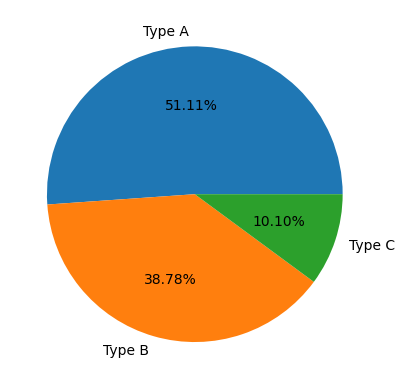

In [ ]:


store_labels = [f"Type {x}" for x in "ABC"]
store_type_percentages = [df["Type"].value_counts().iloc[i] / len(df.index) for i in range(3)]

plt.pie(store_type_percentages, labels=store_labels, autopct="%1.2f%%")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Make sure pandas is imported


# Calculate the mean weekly sales for each holiday and store type
superbowl_means = df[df["Date"].isin(pd.to_datetime(["2010-02-12", "2011-02-11", "2012-02-10"]))].groupby("Type")["Weekly_Sales"].mean().tolist()
labor_day_means = df[df["Date"].isin(pd.to_datetime(["2010-09-10", "2011-09-09", "2012-09-07"]))].groupby("Type")["Weekly_Sales"].mean().tolist()
thanksgiving_means = df[df["Date"].isin(pd.to_datetime(["2010-11-26", "2011-11-25", "2012-11-23"]))].groupby("Type")["Weekly_Sales"].mean().tolist()
christmas_means = df[df["Date"].isin(pd.to_datetime(["2010-12-31", "2011-12-30", "2012-12-28"]))].groupby("Type")["Weekly_Sales"].mean().tolist()

####

width = 0.25
x = np.arange(len(holidays))
holidays = ["Super Bowl", "Labor Day", "Thanksgiving", "Christmas"]
holiday_means = [superbowl_means, labor_day_means, thanksgiving_means, christmas_means]
A_means = [x[0] for x in holiday_means]
B_means = [x[1] for x in holiday_means]
C_means = [x[2] for x in holiday_means]

fig, axes = plt.subplots(figsize=(16, 8))
axes.bar(x - width, A_means, width, label="Type A")
axes.bar(x, B_means, width, label="Type B")
axes.bar(x + width, C_means, width, label="Type C")

axes.set_ylabel("Weekly Average Sales")
axes.set_xticks(x)
axes.set_xticklabels(holidays)
axes.legend()

holiday_mean = df.loc[df["IsHoliday"] == True]["Weekly_Sales"].mean()
non_holiday_mean = df.loc[df["IsHoliday"] == False]["Weekly_Sales"].mean()
plt.axhline(y=holiday_mean, color="black", label="Overall Holiday Week Mean Sales")
plt.axhline(y=non_holiday_mean, color="green", label="Overall Non-Holiday Week Mean Sales")

fig.tight_layout()
plt.show()

NameError: name 'holidays' is not defined

## hiệu suất bán hàng theo loại cửa hàng và dịp lễ
Tính nhất quán về thứ hạng doanh số: Một quan sát nổi bật là sự duy trì nhất quán trong thứ hạng doanh số giữa ba loại cửa hàng qua tất cả bốn dịp lễ. Cụ thể, Type A luôn ghi nhận doanh số trung bình hàng tuần cao nhất, theo sau là Type B với mức doanh số trung bình, và Type C có doanh số trung bình thấp nhất. Điều này cho thấy có những yếu tố cơ bản, có thể liên quan đến mô hình kinh doanh, quy mô hoạt động, hoặc vị trí chiến lược, tạo ra sự khác biệt bền vững trong hiệu suất bán hàng giữa các loại cửa hàng này.

Ảnh hưởng đáng kể của dịp lễ Thanksgiving: Dịp lễ Thanksgiving dường như có tác động đặc biệt lớn đến doanh số của cả ba loại cửa hàng, nhưng đáng chú ý nhất là đối với Type A, khi doanh số trung bình hàng tuần tăng vọt lên mức cao nhất so với bất kỳ dịp lễ nào khác. Type B cũng cho thấy sự tăng trưởng doanh số đáng kể trong dịp Thanksgiving. Ngược lại, Type C chỉ ghi nhận một sự tăng nhẹ, cho thấy mức độ ảnh hưởng của Thanksgiving đến loại cửa hàng này là không đáng kể so với Type A và Type B.

Sự suy giảm doanh số sau Thanksgiving: Sau đỉnh điểm doanh số vào dịp Thanksgiving, doanh số trung bình hàng tuần của cả ba loại cửa hàng đều có xu hướng giảm vào dịp Christmas. Tuy nhiên, mức độ suy giảm này khác nhau giữa các loại:

Type A vẫn duy trì được mức doanh số tương đối cao vào Christmas, mặc dù không bằng Thanksgiving.
Type B chứng kiến sự sụt giảm đáng kể, quay trở lại mức doanh số tương đương hoặc thậm chí thấp hơn so với Super Bowl và Labor Day.
Type C có mức giảm mạnh nhất, đạt doanh số thấp nhất trong tất cả các dịp lễ vào dịp Christmas.
Hiệu suất tương đối ổn định trong Super Bowl và Labor Day: So với sự biến động rõ rệt trong Thanksgiving và Christmas, doanh số trung bình hàng tuần của cả ba loại cửa hàng có vẻ tương đối ổn định hơn trong hai dịp lễ Super Bowl và Labor Day. Sự khác biệt về doanh số giữa các loại cửa hàng vẫn duy trì tương tự như xu hướng chung, với Type A dẫn đầu, theo sau là Type B và Type C.

So sánh với các mức trung bình:

Hai đường ngang màu đen và xanh lá cây trên biểu đồ có thể đại diện cho các mức doanh số trung bình khác nhau, có lẽ là mức trung bình toàn hệ thống hoặc các mục tiêu doanh số cụ thể.

Doanh số trung bình hàng tuần của Type A thường xuyên vượt qua cả hai mức trung bình này trong tất cả các dịp lễ, cho thấy hiệu suất vượt trội của loại cửa hàng này so với mức chuẩn.
Type B dao động quanh các mức trung bình, đôi khi vượt qua (như vào dịp Thanksgiving) và đôi khi thấp hơn (như vào dịp Christmas).
Type C luôn có doanh số trung bình hàng tuần nằm dưới cả hai mức trung bình, cho thấy hiệu suất kém hơn so với mức chuẩn chung.
** implications for business strategy:**

Những phát hiện từ biểu đồ này gợi ý rằng các yếu tố phân biệt giữa Type A, Type B và Type C (có thể bao gồm quy mô cửa hàng, vị trí, chiến lược sản phẩm, hoạt động marketing, hoặc đặc điểm khách hàng mục tiêu) có tác động sâu sắc đến khả năng tạo ra doanh số, đặc biệt là trong các dịp lễ lớn.

Type A dường như đã xây dựng được một mô hình kinh doanh mạnh mẽ, có khả năng tận dụng tối đa các cơ hội mua sắm cao điểm.
Type B cho thấy sự nhạy cảm hơn với từng dịp lễ cụ thể, với hiệu suất tăng đáng kể vào Thanksgiving nhưng lại giảm vào Christmas.
Type C có thể đang gặp thách thức trong việc thu hút khách hàng và tạo ra doanh số, đặc biệt là trong bối cảnh cạnh tranh gia tăng vào các dịp lễ.

các cửa hàng có kích thước lớn hơn (Type A) nhất quán ghi nhận doanh số trung bình hàng tuần cao hơn đáng kể so với các cửa hàng có kích thước trung bình (Type B) và nhỏ (Type C) trong tất cả các dịp lễ được xem xét.

Điều này củng cố giả thuyết cho rằng kích thước cửa hàng có thể là một yếu tố quan trọng ảnh hưởng đến doanh số. Các cửa hàng lớn hơn, với lợi thế về không gian trưng bày rộng rãi, khả năng chứa nhiều hàng hóa và phục vụ đồng thời lượng lớn khách hàng hơn, có tiềm năng cao hơn để triển khai các chương trình khuyến mãi quy mô lớn, trưng bày sản phẩm hấp dẫn và đa dạng, từ đó thu hút và đáp ứng nhu cầu mua sắm đa dạng của khách hàng, đặc biệt là trong các dịp lễ mua sắm cao điểm.

Tuy nhiên, cần lưu ý rằng kích thước cửa hàng không phải là yếu tố duy nhất quyết định doanh số. Mô hình hoạt động tổng thể của từng loại cửa hàng (ví dụ: chiến lược marketing, quản lý hàng tồn kho, chất lượng dịch vụ khách hàng) và vị trí địa lý chiến lược cũng đóng vai trò then chốt trong việc thu hút khách hàng và tối đa hóa doanh thu. Các cửa hàng lớn (Type A) có thể đồng thời được hưởng lợi từ vị trí đắc địa, khả năng đầu tư vào các chương trình khuyến mãi quy mô lớn và một mô hình hoạt động hiệu quả, tất cả cùng nhau tạo nên hiệu suất bán hàng vượt trội.

Ngược lại, các cửa hàng có kích thước nhỏ hơn (Type C) có thể bị hạn chế về không gian trưng bày và khả năng phục vụ, đồng thời có thể không có đủ nguồn lực để triển khai các chương trình khuyến mãi lớn, dẫn đến doanh số thấp hơn. Tuy nhiên, điều này không loại trừ khả năng các cửa hàng nhỏ hơn có thể thành công nhờ vào một mô hình kinh doanh нишевый (niche), tập trung vào một phân khúc khách hàng cụ thể hoặc một vị trí địa lý đặc biệt thuận lợi cho phân khúc đó.

Tóm lại, biểu đồ này cung cấp bằng chứng trực quan cho thấy có mối tương quan giữa kích thước cửa hàng (được đại diện bởi Type A, B, C) và doanh số bán hàng, đặc biệt trong các dịp lễ. Tuy nhiên, để có một kết luận toàn diện và sâu sắc hơn, cần xem xét thêm các yếu tố khác như mô hình hoạt động và vị trí địa lý của từng loại cửa hàng.

# 5 Phân bố doanh số theo thời gian	— có mùa vụ không?


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Chuyển cột 'Date' thành kiểu datetime
data['Date'] = pd.to_datetime(data['Date'])

# Tạo cột 'Year' (năm) từ cột 'Date'
data['Year'] = data['Date'].dt.year

# Gộp dữ liệu theo năm và tính tổng doanh thu
yearly_sales = data.groupby("Year")["Weekly_Sales"].sum()

# Hàm định dạng: chỉ có dấu phẩy, không ký tự đặc biệt
def format_plain(value, tick_number):
    return '{:,.0f}'.format(value)

# Vẽ biểu đồ
plt.figure(figsize=(8,5))
yearly_sales.plot(kind='bar', color='salmon')
plt.title("Tổng doanh thu theo năm", fontsize=16)
plt.xlabel("Năm", fontsize=14)
plt.ylabel("Tổng doanh thu(usd)", fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Format trục Y thành số có dấu phẩy
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_plain))

plt.tight_layout()
plt.show()


Năm 2011 đạt doanh thu cao nhất: Tổng doanh thu đạt đỉnh vào năm 2011 với giá trị khoảng 1,58 tỷ USD (1,580,000,000 USD). Đây là năm có hiệu suất bán hàng tốt nhất trong giai đoạn khảo sát.
Năm 2010 có doanh thu cao thứ hai: Năm 2010 ghi nhận tổng doanh thu khoảng 1,48 tỷ USD (1,480,000,000 USD), thấp hơn một chút so với năm 2011.
Năm 2012 có doanh thu giảm: Tổng doanh thu giảm đáng kể vào năm 2012, xuống còn khoảng 1,29 tỷ USD (1,290,000,000 USD). Đây là năm có hiệu suất bán hàng thấp nhất trong 3 năm được khảo sát.
Tóm lại:

Trong giai đoạn từ năm 2010 đến 2012, bộ dữ liệu cho thấy một xu hướng tăng trưởng doanh thu từ năm 2010 đến năm 2011, sau đó lại giảm sút vào năm 2012. Năm 2011 là năm có tổng doanh thu cao nhất, trong khi năm 2012 chứng kiến sự sụt giảm đáng kể so với hai năm trước đó.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Chuyển đổi cột Date thành dạng datetime
df['Date'] = pd.to_datetime(df['Date'])

#Thêm cột Năm và Tháng
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

#Tính tổng doanh thu theo Năm và Tháng
monthly_sales = df.groupby(['Year', 'Month'])['Weekly_Sales'].sum().reset_index()

# Tạo cột Year_Month chuẩn
monthly_sales['Year_Month'] = pd.to_datetime(monthly_sales[['Year', 'Month']].assign(DAY=1)) # Corrected line: Changed 'pd.to_dateti' to 'pd.to_datetime'


In [ ]:
import matplotlib.ticker as ticker

plt.figure(figsize=(14, 6))
sns.lineplot(x='Year_Month', y='Weekly_Sales', data=monthly_sales, marker='o', color='coral')

plt.title("Tổng doanh thu hàng tháng", fontsize=16)
plt.xlabel("Thời gian (Năm - Tháng)")
plt.ylabel("Tổng doanh số")
plt.xticks(rotation=45)
plt.grid(True)

# Sửa lại định dạng trục Y thành kiểu tiền tệ đẹp hơn
formatter = ticker.FuncFormatter(lambda x, pos: f'{int(x):,}')
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()


Doanh thu tăng vọt vào khoảng tháng 11 - 12 mỗi năm (cuối năm).Ngược lại, doanh thu giảm mạnh vào tháng 1 hàng năm (đầu năm).

Các tháng giữa năm (khoảng từ tháng 4 đến tháng 9) thường có mức doanh thu dao động quanh mức trung bình, không quá cao cũng không quá thấp.

Sự chênh lệch giữa các tháng có thể lên tới 50 triệu USD hoặc thậm chí hơn giữa tháng thấp điểm và tháng cao điểm.

Ví dụ:

Tháng 12/2010: doanh thu đạt đỉnh hơn 160 triệu USD.

Tháng 1/2011: doanh thu rơi xuống mức thấp chỉ còn khoảng 110 triệu USD.

Điều này cho thấy chênh lệch doanh thu tháng cao và thấp có thể trên 40-50%.

Giải thích nguyên nhân sự chênh lệch doanh thu theo tháng:
Hiệu ứng mùa vụ:

Tháng 11 - 12 trùng với mùa lễ hội lớn như Black Friday, Giáng Sinh (Christmas), và New Year.

Đây là thời điểm khách hàng có xu hướng chi tiêu mạnh tay, mua sắm quà tặng, thực phẩm, đồ trang trí…, dẫn tới doanh thu tăng vọt.

Thời kỳ thấp điểm:

Tháng 1 thường là giai đoạn hậu lễ hội, người tiêu dùng đã chi tiêu nhiều vào cuối năm trước nên có xu hướng thắt chặt chi tiêu.

Ngoài ra, tháng 1 có thể trùng với kỳ nghỉ đông, nhiều gia đình đi du lịch hoặc ít mua sắm hơn.
Chính sách bán hàng: Các chương trình khuyến mãi lớn thường tập trung vào cuối năm, ít hơn vào đầu năm.

Thời tiết: Thời tiết mùa đông ở Mỹ (thị trường gốc của Walmart) cũng ảnh hưởng đến tần suất đi lại mua sắm.

===>>> Tổng doanh thu hàng tháng có sự chênh lệch rõ rệt theo mùa vụ, với đỉnh cao vào cuối năm và thấp điểm vào đầu năm.

Sự chênh lệch này hoàn toàn phù hợp với quy luật tiêu dùng trong thực tế, đặc biệt tại các thị trường lớn như Mỹ.

Khi phân tích dữ liệu doanh số hoặc dự báo doanh thu, cần đặc biệt lưu ý đến yếu tố mùa vụ để xây dựng chiến lược kinh doanh và quản lý tồn kho phù hợp.


Tháng 1 và tháng 2 (ở Mỹ, nơi bộ dữ liệu này thường lấy mẫu) là sau kỳ mua sắm đỉnh điểm:

Tháng 11 có Black Friday, Cyber Monday ➔ doanh số cực cao.

Tháng 12 là Christmas (Giáng Sinh) và Holiday Season ➔ người ta mua sắm rất nhiều quà tặng.

Nhưng sang tháng 1, 2, người tiêu dùng hết tiền hoặc ít nhu cầu mua sắm ➔
➔ Doanh số tụt mạnh
Ở Mỹ:

Tết dương lịch (New Year's Day) chỉ là ngày nghỉ lễ ngắn, người ta không mua sắm nhiều dịp này.

Noël (Christmas) mới là mùa mua sắm "khủng" ➔ tập trung vào tháng 11 - 12.

Sau đó, tháng 1, mọi người nghỉ ngơi, tiết kiệm tiền, rất ít mua sắm.


In [ ]:
df["Date"] = pd.to_datetime(df["Date"])
df["Week"] = df["Date"].dt.isocalendar().week     # Tuần trong năm
df["Month"] = df["Date"].dt.month                 # Tháng
df["Year"] = df["Date"].dt.year                   # Năm
df["Lag_1"] = df["Weekly_Sales"].shift(1)         # Doanh số của tuần trước
df["Rolling_avg_3_week"] = df["Weekly_Sales"].rolling(window=3).mean()  # Trung bình doanh số 3 tuần

df.fillna(value=0, inplace=True)  # Điền giá trị thiếu bằng 0

monthly_sales = df.groupby(by=["Year", "Month"])["Weekly_Sales"].mean().unstack()
# Tính doanh số trung bình hàng tuần theo từng tháng và từng năm

sns.set_style("whitegrid")
sns.set_palette("pastel")

# Vẽ biểu đồ đường cho từng năm
sns.lineplot(x=range(1, 13), y=monthly_sales.iloc[0], linewidth=2.5, label="2010")
sns.lineplot(x=range(1, 13), y=monthly_sales.iloc[1], linewidth=2.5, label="2011")
sns.lineplot(x=range(1, 13), y=monthly_sales.iloc[2], linewidth=2.5, label="2012")

plt.title("Doanh số hàng tháng theo từng năm")
plt.xlabel("Tháng")
plt.ylabel("Doanh số hàng tuần")
plt.show()


Tính mùa vụ rõ rệt: Cả ba năm đều cho thấy một mô hình doanh số theo mùa tương tự, với doanh số tăng lên vào cuối năm.
Sự khác biệt giữa các năm: Có sự khác biệt nhất định về mức doanh số trung bình hàng tuần giữa các năm tại cùng một thời điểm.
Đỉnh doanh số cuối năm: Tháng 12 luôn là tháng có doanh số hàng tuần trung bình cao nhất trong cả ba năm.
Đáy doanh số đầu năm: Tháng 1 thường là tháng có doanh số hàng tuần trung bình thấp nhất hoặc gần thấp nhất trong cả ba năm.

Năm 2010 (xanh lam nhạt):
Doanh số thấp nhất vào tháng 1.
Có sự tăng trưởng đáng kể từ tháng 1 đến tháng 2.
Duy trì mức tương đối ổn định từ tháng 2 đến tháng 5.
Tăng nhẹ vào tháng 6.
Giảm nhẹ vào tháng 7.
Tăng trở lại vào tháng 8 và duy trì đến tháng 11.
Đạt đỉnh cao nhất vào tháng 12.
Năm 2011 (cam nhạt):
Doanh số thấp nhất vào tháng 1.
Tăng trưởng mạnh từ tháng 1 đến tháng 3.
Giảm nhẹ vào tháng 4.
Tăng trở lại vào tháng 5 và đạt đỉnh thứ hai trong năm vào tháng 6.
Giảm đáng kể từ tháng 6 đến tháng 9, đạt đáy thứ hai trong năm vào tháng 9.
Tăng trưởng mạnh mẽ từ tháng 9 đến tháng 12, đạt đỉnh cao nhất vào tháng 12.
Năm 2012 (xanh lá cây nhạt):
Doanh số thấp nhất vào tháng 1.
Tăng trưởng ổn định từ tháng 1 đến tháng 6, đạt đỉnh thứ hai trong năm vào tháng 6.
Giảm nhẹ vào tháng 7.
Tiếp tục giảm vào tháng 8 và đạt đáy thứ hai trong năm vào tháng 9.
Tăng trưởng mạnh mẽ từ tháng 9 đến tháng 12, đạt đỉnh cao nhất vào tháng 12.
So sánh giữa các năm:

Mức doanh số chung: Nhìn chung, mức doanh số trung bình hàng tuần có vẻ tương đương nhau giữa các năm, mặc dù có những biến động nhỏ theo từng tháng.
Thời điểm đỉnh và đáy: Thời điểm đạt đỉnh (tháng 12) và đáy (tháng 1) doanh số khá nhất quán qua các năm, củng cố tính mùa vụ.
Biến động giữa năm: Có một số khác biệt về biến động doanh số giữa các tháng trong năm giữa các năm. Ví dụ, năm 2011 có sự sụt giảm đáng kể từ tháng 6 đến tháng 9, trong khi năm 2010 và 2012 không có sự sụt giảm mạnh như vậy.
Kết luận:

Biểu đồ cho thấy rõ ràng tính mùa vụ mạnh mẽ trong doanh số hàng tuần trung bình, với tháng 12 là tháng bán hàng tốt nhất và tháng 1 là tháng bán hàng chậm nhất. Mặc dù có những khác biệt nhỏ giữa các năm về mức doanh số và biến động giữa các tháng, mô hình mùa vụ chung vẫn được duy trì. Điều này cho thấy các yếu tố theo mùa (ví dụ: các ngày lễ cuối năm) có ảnh hưởng rất lớn đến doanh số bán hàng.

In [ ]:
# Tính trung bình doanh số từng tuần từng năm
df['Year'] = df['Date'].dt.year
df['Week'] = df['Date'].dt.isocalendar().week

weekly_avg_sales = df.groupby(['Year', 'Week'])['Weekly_Sales'].mean().reset_index()

# Lấy danh sách các năm có trong dữ liệu
years = weekly_avg_sales['Year'].unique()

# Vẽ từng năm riêng biệt
import matplotlib.pyplot as plt
import seaborn as sns

for year in years:
    plt.figure(figsize=(12, 5))

    # Lọc dữ liệu từng năm
    data_year = weekly_avg_sales[weekly_avg_sales['Year'] == year]

    # Vẽ biểu đồ
    sns.lineplot(x='Week', y='Weekly_Sales', data=data_year, marker='o', color='coral')

    plt.title(f"Doanh số trung bình hàng tuần - Năm {year}", fontsize=16)
    plt.xlabel("Tuần trong năm")
    plt.ylabel("Doanh số trung bình")
    plt.xticks(range(1, 54, 2))  # chỉnh x cho đẹp: từ tuần 1 đến tuần 53
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# so sánh từng tuần qua các năm
Cả ba biểu đồ doanh số trung bình hàng tuần cho các năm 2010, 2011 và 2012 đều cho thấy một mô hình mùa vụ rõ rệt và nhất quán, cho thấy doanh số bán hàng chịu ảnh hưởng mạnh mẽ bởi các yếu tố thời gian trong năm.
Đỉnh Doanh Số Cuối Năm (Tháng 12): Đây là đặc điểm nổi bật nhất, khi doanh số hàng tuần đều đạt mức cao nhất vào tuần cuối cùng của tháng 12 trong cả ba năm. Điều này phản ánh rõ ràng tác động của mùa mua sắm lễ hội cuối năm, đặc biệt là lễ Giáng Sinh, lên doanh số bán hàng.
Đáy Doanh Số Đầu Năm (Tháng 1): Ngược lại, tháng 1 thường ghi nhận mức doanh số trung bình hàng tuần thấp nhất hoặc gần thấp nhất trong cả ba năm. Điều này có thể là do sự giảm chi tiêu sau mùa lễ hội và thiếu vắng các sự kiện mua sắm lớn vào đầu năm.
Biến Động Giữa Năm (Tháng 2 - Tháng 10): Trong khoảng thời gian này, doanh số có sự biến động lên xuống, cho thấy ảnh hưởng của các yếu tố khác như các chương trình khuyến mãi nhỏ lẻ, các ngày lễ không lớn, và các yếu tố theo mùa khác (ví dụ: mùa tựu trường). Tuy nhiên, các biến động này thường không có quy luật rõ ràng và có sự khác biệt giữa các năm.


- Mặc dù mô hình mùa vụ chung được duy trì, có những khác biệt đáng chú ý về cách mùa vụ ảnh hưởng đến doanh số qua từng năm:

Mức Đỉnh và Đáy: Mức doanh số tuyệt đối tại các đỉnh (tháng 12) và đáy (tháng 1) có sự thay đổi nhẹ qua các năm. Đỉnh doanh số cuối năm có xu hướng giảm dần từ năm 2010 (cao nhất) đến năm 2012 (thấp nhất), cho thấy có thể có sự thay đổi trong sức mua hoặc hiệu quả của mùa mua sắm lễ hội qua thời gian. Tương tự, mức đáy đầu năm cũng có sự biến động nhẹ.
Biến Động Giữa Năm: Sự biến động doanh số trong các tháng giữa năm có sự khác biệt rõ rệt giữa các năm. Năm 2010 có vẻ ổn định hơn, trong khi năm 2011 và 2012 cho thấy nhiều dao động lên xuống hơn, có thể phản ánh sự khác biệt trong các chiến lược khuyến mãi hoặc các yếu tố thị trường tạm thời.
Thời Điểm và Cường Độ Tăng Trưởng: Thời điểm bắt đầu và tốc độ tăng trưởng doanh số hướng tới đỉnh cuối năm có thể khác nhau giữa các năm. Ví dụ, năm 2011 có sự tăng trưởng mạnh mẽ từ khá sớm (cuối quý 3), trong khi năm 2012 sự tăng trưởng có vẻ tập trung hơn vào những tuần cuối cùng.
Kết luận về Ảnh Hưởng của Mùa Vụ Qua Các Năm:

Tính mùa vụ có một ảnh hưởng mạnh mẽ và ổn định lên doanh số bán hàng hàng tuần trong cả ba năm được khảo sát, với mùa lễ hội cuối năm là động lực chính và đầu năm là giai đoạn thấp điểm. Tuy nhiên, cường độ và diễn biến chi tiết của ảnh hưởng mùa vụ có sự thay đổi nhẹ qua các năm.

Sự suy giảm dần ở mức đỉnh doanh số cuối năm (từ 2010 đến 2012) có thể gợi ý về những thay đổi trong xu hướng tiêu dùng hoặc hiệu quả của các chương trình kích cầu vào dịp lễ. Sự khác biệt trong biến động doanh số giữa năm cho thấy các yếu tố không theo mùa có thể có tác động khác nhau qua từng năm.

# 5.5 Ảnh hưởng ngày nghỉ lễ	IsHoliday ảnh hưởng doanh số thế nào? Markdown có hiệu quả không?	Giảm giá có làm doanh số tăng?


In [ ]:
print(data.groupby('IsHoliday')['Weekly_Sales'].mean())


In [ ]:
holiday_sales = data.groupby("IsHoliday")["Weekly_Sales"].mean()

holiday_sales.plot(kind='bar', color=['skyblue', 'orange'], title="Doanh thu trung bình: Tuần lễ vs Tuần thường")
plt.xticks([0, 1], ["Tuần thường", "Tuần lễ"], rotation=0)
plt.ylabel("Doanh thu trung bình")
plt.grid(axis='y')
plt.show()


In [ ]:
markdown_cols = [f"MarkDown{i}" for i in range(1, 6)]
correlations = data[markdown_cols + ['Weekly_Sales']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(correlations, annot=True, cmap='YlGnBu')
plt.title("Tương quan giữa MarkDown và Doanh số")
plt.show()


MarkDown4 có tương quan dương mạnh nhất với Weekly_Sales: Hệ số tương quan giữa "MarkDown4" và "Weekly_Sales" là 0.69. Đây là giá trị dương lớn nhất, cho thấy chương trình khuyến mại được thể hiện ở cột MarkDown4 có ảnh hưởng tích cực và mạnh mẽ nhất đến doanh số hàng tuần. Khi có chương trình MarkDown4, doanh số bán hàng có xu hướng tăng lên đáng kể.

MarkDown1 có tương quan dương đáng kể với Weekly_Sales: Hệ số tương quan giữa "MarkDown1" và "Weekly_Sales" là 0.11. Đây là một tương quan dương yếu, cho thấy chương trình khuyến mại MarkDown1 có ảnh hưởng tích cực nhưng không mạnh mẽ đến doanh số hàng tuần.

MarkDown2 và MarkDown5 có tương quan dương rất yếu với Weekly_Sales: Hệ số tương quan giữa "MarkDown2" và "Weekly_Sales" là 0.11, tương tự MarkDown1. Hệ số tương quan giữa "MarkDown5" và "Weekly_Sales" là 0.064. Cả hai đều cho thấy ảnh hưởng tích cực nhưng rất nhỏ đến doanh số hàng tuần. Có thể các chương trình khuyến mại này không đủ hấp dẫn hoặc không được triển khai hiệu quả để tạo ra sự tăng trưởng đáng kể trong doanh số.

MarkDown3 có tương quan âm rất yếu với Weekly_Sales: Hệ số tương quan giữa "MarkDown3" và "Weekly_Sales" là -0.062. Đây là một tương quan âm rất yếu, cho thấy chương trình khuyến mại MarkDown3 có xu hướng tác động tiêu cực rất nhỏ đến doanh số hàng tuần. Điều này có thể là do chương trình này không phù hợp với thị hiếu khách hàng, áp dụng cho các sản phẩm có nhu cầu thấp, hoặc trùng với các yếu tố tiêu cực khác ảnh hưởng đến doanh số. Tuy nhiên, mức độ ảnh hưởng này là không đáng kể.

Tương quan giữa các chương trình khuyến mại (MarkDown):

Có một số tương quan dương giữa các chương trình khuyến mại với nhau, đáng chú ý nhất là giữa MarkDown1 và MarkDown4 (0.69), cho thấy có khả năng hai loại khuyến mại này thường được triển khai cùng nhau hoặc có liên quan đến nhau.
Các tương quan khác giữa các cột MarkDown thường yếu hơn.
Kết luận về ảnh hưởng của khuyến mại đến doanh số:

Dựa trên ma trận tương quan này:

Chương trình khuyến mại MarkDown4 có khả năng là động lực tăng trưởng doanh số mạnh mẽ nhất. Việc tập trung và tối ưu hóa chương trình này có thể mang lại hiệu quả cao nhất.
MarkDown1, MarkDown2 và MarkDown5 có tác động tích cực nhưng tương đối nhỏ đến doanh số. Cần xem xét lại hiệu quả của các chương trình này, có thể cần điều chỉnh hoặc thay thế để tăng cường tác động.
MarkDown3 có tương quan âm yếu với doanh số, gợi ý rằng chương trình này có thể không hiệu quả và cần được đánh giá lại.
Lưu ý quan trọng:

Tương quan không phải là nhân quả: Ma trận tương quan chỉ cho thấy mối quan hệ tuyến tính giữa các biến, không chứng minh quan hệ nhân quả. Có thể có các yếu tố khác ảnh hưởng đồng thời đến cả chương trình khuyến mại và doanh số.
Độ trễ: Biểu đồ không xem xét độ trễ giữa thời điểm triển khai khuyến mại và thời điểm doanh số tăng.
Loại hình khuyến mại: Chúng ta không biết chi tiết về từng loại chương trình khuyến mại (ví dụ: giảm giá phần trăm, mua X tặng Y). Loại hình khuyến mại có thể ảnh hưởng đến hiệu quả của nó.

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(data["MarkDown4"], data["Weekly_Sales"], alpha=1)
plt.title("MarkDown4 vs Weekly Sales")
plt.xlabel("MarkDown4")
plt.ylabel("Weekly Sales")
plt.grid(True)
plt.show()


Phân tích cho thấy tuần có lễ (IsHoliday = True) thường có doanh số trung bình cao hơn, phản ánh xu hướng tiêu dùng tăng vào các dịp lễ. Ngoài ra, một số chương trình giảm giá (Markdown) có tương quan dương với doanh thu, đặc biệt là MarkDown1 và MarkDown4. Điều này chứng tỏ giảm giá có thể tác động tích cực đến doanh thu,


[ ]
1


Nhận xét về ảnh hưởng của MarkDown4 đến Weekly_Sales:

Dựa trên biểu đồ phân tán, chúng ta có thể thấy một số điểm đáng chú ý, củng cố nhận xét về tương quan dương mạnh từ ma trận tương quan trước đó:

Xu hướng tăng doanh số khi có MarkDown4: Mặc dù các điểm phân tán rộng, có một xu hướng chung cho thấy khi giá trị của MarkDown4 tăng lên (tức là mức độ khuyến mại lớn hơn), doanh số hàng tuần cũng có xu hướng tăng lên. Điều này đặc biệt rõ ràng khi so sánh các điểm ở vùng MarkDown4 gần 0 với các vùng có giá trị MarkDown4 cao hơn.

Sự phân tán lớn cho thấy nhiều yếu tố khác ảnh hưởng: Tuy nhiên, sự phân tán rộng của các điểm cho thấy MarkDown4 không phải là yếu tố duy nhất, hoặc thậm chí là yếu tố quyết định hoàn toàn doanh số hàng tuần. Với cùng một mức độ MarkDown4, doanh số hàng tuần có thể dao động trong một phạm vi rất lớn. Điều này ngụ ý rằng có nhiều yếu tố khác như loại sản phẩm, vị trí cửa hàng, thời điểm trong năm, các chương trình khuyến mại khác, và các yếu tố bên ngoài khác cũng đóng vai trò quan trọng trong việc quyết định doanh số.

Tác động rõ rệt khi MarkDown4 khác 0: Khi MarkDown4 có giá trị khác 0 (tức là có áp dụng chương trình khuyến mại 4), chúng ta thường thấy các điểm dữ liệu trải dài trên một phạm vi doanh số rộng hơn và có xu hướng đạt các giá trị doanh số cao hơn so với khi MarkDown4 bằng 0 (nơi doanh số tập trung ở mức thấp hơn).

Biểu đồ này, kết hợp với hệ số tương quan cao, mang lại những ý nghĩa quan trọng cho việc quản lý và tối ưu hóa chiến lược khuyến mại:

MarkDown4 là một công cụ hiệu quả để thúc đẩy doanh số: Việc triển khai chương trình khuyến mại MarkDown4 có khả năng cao dẫn đến sự tăng trưởng đáng kể trong doanh số hàng tuần.
Cần tối ưu hóa mức độ khuyến mại: Do sự phân tán lớn, việc xác định mức độ khuyến mại tối ưu cho MarkDown4 là rất quan trọng. Mức khuyến mại quá thấp có thể không tạo ra tác động đáng kể, trong khi mức quá cao có thể làm giảm lợi nhuận. Cần phân tích thêm để tìm ra điểm cân bằng tốt nhất.
Đo lường và đánh giá hiệu quả: Việc theo dõi chặt chẽ tác động của MarkDown4 lên doanh số là rất quan trọng để đánh giá hiệu quả thực tế và đưa ra các điều chỉnh cần thiết cho các chiến dịch khuyến mại trong tương lai.
Tóm lại:

Biểu đồ phân tán củng cố vai trò quan trọng của chương trình khuyến mại MarkDown4 trong việc thúc đẩy doanh số bán hàng.

# 5.6 Tương quan giữa các biến với doanh số

 Dùng heatmap, Biến phân loại

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Tạo thư mục 'plots' nếu chưa tồn tại
if not os.path.exists('plots'):
    os.makedirs('plots')

plt.figure(figsize=(15,8))

# Định nghĩa danh sách các cột số
num_col = ['Weekly_Sales', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
           'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

# Tính ma trận tương quan giữa các cột số
corr = data[num_col].corr()

# Vẽ biểu đồ nhiệt (heatmap) cho ma trận tương quan
sns.heatmap(corr, vmax=1.0, annot=True)
plt.title('Ma trận tương quan', fontsize=16)

# Lưu biểu đồ vào thư mục 'plots'
plt.savefig('plots/correlation_matrix.png')

# Hiển thị biểu đồ
plt.show()


Với Weekly_Sales (Doanh số hàng tuần):

Size (Kích thước): Có tương quan dương yếu (0.2) với doanh số hàng tuần. Điều này gợi ý rằng các cửa hàng có kích thước lớn hơn có xu hướng có doanh số cao hơn, nhưng mối quan hệ này không quá mạnh.
MarkDown1, MarkDown2, MarkDown4, MarkDown5: Có tương quan dương rất yếu (0.11, 0.11, 0.085, 0.064) với doanh số hàng tuần. Điều này cho thấy các chương trình giảm giá có xu hướng làm tăng doanh số, nhưng tác động riêng lẻ của từng chương trình là nhỏ.
MarkDown3: Có tương quan dương rất yếu (0.02) với doanh số hàng tuần, gần như không có tương quan tuyến tính.
Temperature (Nhiệt độ), Fuel_Price (Giá nhiên liệu), CPI (Chỉ số giá tiêu dùng), Unemployment (Tỷ lệ thất nghiệp): Có tương quan rất yếu, gần bằng không hoặc âm nhẹ với doanh số hàng tuần. Điều này cho thấy các yếu tố kinh tế vĩ mô và thời tiết dường như không có mối quan hệ tuyến tính mạnh mẽ trực tiếp với doanh số hàng tuần.
Mối tương quan giữa các đặc trưng độc lập:

Tương quan dương đáng chú ý:
Size và các MarkDown (đặc biệt MarkDown1: 0.53, MarkDown2: 0.44, MarkDown4: 0.38, MarkDown5: 0.3): Các cửa hàng lớn hơn có xu hướng triển khai các chương trình giảm giá mạnh mẽ hơn.
Temperature và Fuel_Price (0.14): Có một tương quan dương nhẹ, có thể do nhu cầu đi lại tăng khi thời tiết ấm hơn, dẫn đến giá nhiên liệu tăng.
Temperature và CPI (0.18): Tương quan dương nhẹ, có thể do nhu cầu tiêu dùng tăng theo nhiệt độ, đẩy CPI lên.
Temperature và Unemployment (-0.3): Tương quan âm nhẹ, có thể do khi kinh tế tốt (thời tiết ấm áp có thể kích thích một số ngành), tỷ lệ thất nghiệp giảm.
CPI và Unemployment (-0.3): Tương quan âm nhẹ, có thể do khi lạm phát cao, người dân có xu hướng tìm kiếm việc làm nhiều hơn.
Các MarkDown có tương quan dương với nhau: Đặc biệt MarkDown1 và MarkDown2 (0.39), MarkDown1 và MarkDown4 (0.69), MarkDown2 và MarkDown4 (0.21) cho thấy các chương trình giảm giá có thể được triển khai đồng thời hoặc có liên quan.
Tương quan âm đáng chú ý:
Temperature và các MarkDown (tương quan âm yếu): Nhiệt độ cao hơn có xu hướng đi kèm với mức giảm giá thấp hơn một chút.
Fuel_Price và các MarkDown (tương quan âm yếu): Giá nhiên liệu cao hơn có xu hướng đi kèm với mức giảm giá thấp hơn một chút.
CPI và các MarkDown (tương quan âm yếu): CPI cao hơn có xu hướng đi kèm với mức giảm giá thấp hơn một chút.
Kết luận chung:

Kích thước cửa hàng (Size) có ảnh hưởng tích cực nhất (dù không quá mạnh) đến doanh số hàng tuần.
Các chương trình giảm giá (MarkDown) có tác động tăng doanh số nhưng riêng lẻ thì yếu. Tuy nhiên, sự tương quan giữa Size và các MarkDown cho thấy các cửa hàng lớn có xu hướng sử dụng giảm giá nhiều hơn, có thể là một yếu tố góp phần vào doanh số cao hơn của họ.
Các yếu tố kinh tế vĩ mô và thời tiết có mối tương quan tuyến tính rất yếu hoặc không đáng kể với doanh số hàng tuần. Điều này không có nghĩa là chúng không ảnh hưởng đến doanh số, mà có thể mối quan hệ này phức tạp hơn hoặc không phải là tuyến tính trực tiếp.
Có mối tương quan giữa các đặc trưng độc lập, cho thấy sự tương tác và phụ thuộc lẫn nhau giữa các yếu tố này. Ví dụ, kích thước cửa hàng có liên quan đến việc triển khai các chương trình giảm giá.

In [ ]:

# Chuyển đổi cột Date về dạng datetime để xử lý thời gian
features["Date"] = pd.to_datetime(features["Date"])
train["Date"] = pd.to_datetime(train["Date"])

# Gộp các bảng lại thành full_df
df = train.merge(features, on=["Store", "Date", "IsHoliday"], how="left")
df = df.merge(stores, on="Store", how="left")

# Lưu lại vào full_df để sử dụng tiếp
full_df = df.copy()

# Tiếp tục vẽ biểu đồ như yêu cầu
plt.figure(figsize=(14, 6))
sns.set(style="whitegrid", palette="pastel")

# Biểu đồ 1: Giá xăng vs Doanh số
plt.subplot(1, 2, 1)
sns.scatterplot(data=full_df, x="Fuel_Price", y="Weekly_Sales", alpha=0.3)
plt.title("Ảnh hưởng của Giá Xăng đến Doanh Số")
plt.xlabel("Giá Xăng ($)")
plt.ylabel("Doanh Số Hàng Tuần")

# Biểu đồ 2: Nhiệt độ vs Doanh số
plt.subplot(1, 2, 2)
sns.scatterplot(data=full_df, x="Temperature", y="Weekly_Sales", alpha=0.3, color="orange")
plt.title("Ảnh hưởng của Nhiệt Độ đến Doanh Số")
plt.xlabel("Nhiệt Độ (°F)")
plt.ylabel("Doanh Số Hàng Tuần")

plt.tight_layout()
plt.show()


Dạng biểu đồ hình chuông ngược (parabol): doanh số tăng dần đến khoảng 50–60°F (~10–15°C) rồi giảm nhẹ về hai phía.

Ở mức nhiệt độ thấp (<30°F / 0°C) hoặc cao (>80°F / ~27°C), doanh số có xu hướng giảm.

Các đỉnh cao nhất về doanh số tập trung ở nhiệt độ ôn hòa (45–65°F).

vì
Nhiệt độ lý tưởng giúp khách hàng dễ dàng ra ngoài, mua sắm, tổ chức sự kiện, tiệc…

Trời quá lạnh  (mùa đông) hoặc quá nóng  (mùa hè) có thể giảm nhu cầu mua sắm tại cửa hàng, nhất là các khu không có trung tâm thương mại trong nhà.


  - Thời tiết quá nóng khiến người tiêu dùng ngại ra ngoài:

Khách hàng có thể tránh ra đường mua sắm khi thời tiết quá nóng, đặc biệt là nếu cửa hàng không có điều hòa tốt.

Thay đổi hành vi tiêu dùng theo mùa:

Mùa hè thường là mùa đi du lịch hoặc nghỉ mát, người dân chi tiêu ít hơn ở siêu thị địa phương.

Ảnh hưởng đến chuỗi cung ứng:

Nhiệt độ cao có thể làm ảnh hưởng đến việc bảo quản, vận chuyển thực phẩm — đặc biệt là hàng tươi sống, dẫn đến việc giảm hàng hóa chất lượng → ảnh hưởng đến doanh số.

Giảm nhu cầu một số sản phẩm:

Nhiều mặt hàng bán chạy trong thời tiết mát hoặc lạnh (ví dụ: đồ ăn nóng, áo khoác, thiết bị sưởi…) sẽ giảm sức mua trong mùa nóng.

==>  Quá lạnh hoặc quá nóng đều khiến doanh số giảm, còn khoảng giữa là thời điểm “vàng” cho doanh số

# 6. Xây dựng và đánh giá mô hình

#6.1 Xử lý dữ liệu đầu vào



In [ ]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# kết hợp các bảng
train_data = train.merge(stores, on='Store', how='left')
train_data = train_data.merge(features, on=['Store', 'Date', 'IsHoliday'], how='left')

test_data = test.merge(stores, on='Store', how='left')
test_data = test_data.merge(features, on=['Store', 'Date', 'IsHoliday'], how='left')

In [ ]:
# Kiểm tra tính dừng của chuỗi thời gian
def check_stationarity(series, window=12, title=''):
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()

    plt.figure(figsize=(12, 6))
    plt.plot(series, label='Original')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label='Rolling Std')
    plt.legend()
    plt.title(f'Rolling Statistics - {title}')
    plt.show()

    adf_result = adfuller(series.dropna())
    print(f"ADF Test p-value: {adf_result[1]:.4f}")
    return adf_result[1] <= 0.05

# Chuẩn bị dữ liệu chuỗi thời gian
time_series_data = train_data.groupby(pd.to_datetime(train_data['Date']))['Weekly_Sales'].sum()
time_series_data = time_series_data.resample('W').sum()
print("\nKiểm tra tính dừng:")
is_stationary = check_stationarity(time_series_data, title='Original Data')

#6.2 Mô hình truyền thống – Linear Regression, Random Forest, Decision Tree, SVR, KNN,Gradient Boosting

In [ ]:
# Chuẩn bị dữ liệu cho ML models
def prepare_ml_data(train_data, test_data=None):
    features = ['Store', 'Dept', 'IsHoliday', 'Type', 'Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Year', 'Month', 'Week', 'Day', 'DayOfWeek', 'Quarter']
    features = [f for f in features if f in train_data.columns]
    #Lọc ra các tính năng không tồn tại trong dữ liệu
    features = [f for f in features if f in train_data.columns]

    X = train_data[features]
    y = train_data['Weekly_Sales']

    # Chuẩn bị dữ liệu thử nghiệm nếu được cung cấp
    X_test = None
    if test_data is not None:
        X_test = test_data[features]

    # Xác định các tính năng phân loại và số
    categorical_features = ['Store', 'Dept', 'IsHoliday', 'Type', 'Year', 'Month', 'Week', 'Day', 'DayOfWeek', 'Quarter']
    categorical_features = [f for f in categorical_features if f in features]

    numerical_features = [f for f in features if f not in categorical_features]

    # Create preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ]
    )

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_val, y_train, y_val, X_test, preprocessor, features

print("\nPreparing ML data...")
X_train, X_val, y_train, y_val, _, preprocessor, features = prepare_ml_data(train_data)

In [ ]:
# prompt: hiển thị bảng dữ liệu sau khi chuẩn bị dữ liệu ML models

import pandas as pd

# Assuming 'df' is your DataFrame after data preprocessing
# Replace 'df' with the actual name of your DataFrame if it's different

# Display the DataFrame
df


# If you want to display only a specific number of rows:
# print(df.head(10))  # Display the first 10 rows
# print(df.tail(5))  # Display the last 5 rows

# or to display specific columns:
# print(df[['Column1', 'Column2', 'Column3']])


In [ ]:
# Hàm cho ML models
def train_ml_models(X_train, X_val, y_train, y_val, preprocessor):
    # Fill NaN values with 0 for markdown columns
    markdown_cols = [col for col in X_train.columns if 'MarkDown' in col]
    X_train[markdown_cols] = X_train[markdown_cols].fillna(0)
    X_val[markdown_cols] = X_val[markdown_cols].fillna(0)

    models = {
        'Linear Regression': LinearRegression(),
        'Decision Tree': DecisionTreeRegressor(random_state=42),
        'Random Forest': RandomForestRegressor(
            n_estimators=50,        # Giảm từ mặc định 100
            max_depth=15,           # Giới hạn độ sâu
            min_samples_split=20,   # Tăng ngưỡng phân tách
            min_samples_leaf=10,    # Tăng kích thước lá tối thiểu
            max_features='sqrt',    # Giảm số lượng tính năng xem xét
            bootstrap=True,         # Sử dụng bootstrap mẫu
            random_state=42,
            n_jobs=-1               # Sử dụng tất cả các lõi
        ),
        'SVR': LinearSVR(
            # Thay đổi loss function thành 'squared_epsilon_insensitive'
            loss='squared_epsilon_insensitive',
            epsilon=0.1,
            C=1.0,
            dual=False,       # Sử dụng công thức primal cho dữ liệu lớn
            random_state=42,
            max_iter=1000
        ),
        'Gradient Boosting': GradientBoostingRegressor(
            n_estimators=50,        # Giảm số lượng cây
            max_depth=3,            # Giới hạn độ sâu cây
            learning_rate=0.1,      # Tăng learning rate để giảm số cây cần thiết
            subsample=0.8,          # Sử dụng 80% mẫu cho mỗi cây
            min_samples_split=20,   # Tăng số mẫu tối thiểu để phân tách
            min_samples_leaf=10,    # Tăng số mẫu tối thiểu ở nút lá
            random_state=42
        ),
        'KNN':  KNeighborsRegressor(
            n_neighbors=5,           # Giảm số lượng neighbors
            weights='distance',      # Cân nhắc khoảng cách khi dự đoán
            algorithm='kd_tree',     # Sử dụng kd_tree cho tìm kiếm nhanh hơn
            leaf_size=30,            # Tăng kích thước lá cho kd_tree
            p=2,                     # Khoảng cách Euclidean
            n_jobs=-1                # Sử dụng tất cả các lõi CPU
        )
    }

    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)

        results[name] = {
            'RMSE': np.sqrt(mean_squared_error(y_val, y_pred)),
            'MAE': mean_absolute_error(y_val, y_pred),
            'R2': r2_score(y_val, y_pred)
        }
    return results

print("\nTraining ML models...")
ml_results = train_ml_models(X_train, X_val, y_train, y_val, preprocessor)

In [ ]:
results_df = pd.DataFrame(ml_results).T.sort_values('RMSE')
display(results_df)

In [ ]:
plt.figure(figsize=(10, 6))

# Plot RMSE
plt.subplot(2, 1, 1)
plt.bar(results_df.index, results_df['RMSE'], color='skyblue')
plt.title('RMSE for different models')
plt.ylabel('RMSE')
plt.xticks(rotation=45)

# Plot MAE
plt.subplot(2, 1, 2)
plt.bar(results_df.index, results_df['MAE'], color='lightcoral')
plt.title('MAE for different models')
plt.ylabel('MAE')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


#6.3 Deep Learning – LSTM neural network

In [ ]:
# Chuẩn bị cho LSTM
def prepare_lstm_data(train_data, sequence_length=4):
    store_dept_groups = train_data.groupby(['Store', 'Dept'])
    X_sequences, y_values = [], []

    for _, group in store_dept_groups:
        group = group.sort_values('Date')
        sales = group['Weekly_Sales'].values
        for i in range(len(sales) - sequence_length):
            X_sequences.append(sales[i:i+sequence_length])
            y_values.append(sales[i+sequence_length])

    X_lstm = np.array(X_sequences).reshape(-1, sequence_length, 1)
    y_lstm = np.array(y_values)
    return train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

print("\nPreparing LSTM data...")
X_train_lstm, X_val_lstm, y_train_lstm, y_val_lstm = prepare_lstm_data(train_data)

In [ ]:
# Hàm cho LSTM
def train_lstm(X_train, X_val, y_train, y_val):
    model = Sequential([
        LSTM(64, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True),
        Dropout(0.2),
        LSTM(32, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, y_train, epochs=100, batch_size=5000,
                    validation_data=(X_val, y_val), verbose=1)

    # Plot training history
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('LSTM Training History')
    plt.legend()
    plt.show()

    y_pred = model.predict(X_val)
    return {
        'RMSE': np.sqrt(mean_squared_error(y_val, y_pred)),
        'MAE': mean_absolute_error(y_val, y_pred),
        'R2': r2_score(y_val, y_pred)
    }

print("\nTraining LSTM...")
lstm_result = train_lstm(X_train_lstm, X_val_lstm, y_train_lstm, y_val_lstm)


#6.4 Time Series models – ARIMA, SARIMA

In [ ]:
# chuẩn bị dữ liệu cho ARIMA/SARIMA
def prepare_time_series_data(train_data):
    time_series_data = train_data.groupby('Date')['Weekly_Sales'].sum().reset_index()
    time_series_data['Date'] = pd.to_datetime(time_series_data['Date'])
    time_series_data.set_index('Date', inplace=True)
    time_series_data = time_series_data.resample('W').sum()
    return time_series_data

print("\nPreparing time series data...")
time_series_data = prepare_time_series_data(train_data)

In [ ]:
# Hàm cho ARIMA/SARIMA
def train_arima_models(time_series_data, is_stationary):
    train_size = int(len(time_series_data) * 0.8)
    train, test = time_series_data.iloc[:train_size], time_series_data.iloc[train_size:]

    results = {}
    # Grid Search cho ARIMA
    print("\nĐang thực hiện Grid Search cho ARIMA...")
    best_aic = float('inf')
    best_order = None

    # Các giá trị tham số
    p_values = range(0, 5)
    d_values = range(0, 1)
    q_values = range(0, 3)

    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = ARIMA(train, order=(p, d, q))
                    model_fit = model.fit()

                    if model_fit.aic < best_aic:
                        best_aic = model_fit.aic
                        best_order = (p, d, q)
                        print(f"New best ARIMA{best_order} - AIC:{best_aic:.2f}")

                except Exception as e:
                    continue

    print(f"\nBest ARIMA Order: {best_order} - AIC: {best_aic:.2f}")

    # Huấn luyện mô hình ARIMA
    final_arima = ARIMA(train, order=best_order)
    arima_model = final_arima.fit()
    arima_preds = arima_model.forecast(steps=len(test))

    # Lưu kết quả
    results['ARIMA'] = {
        'RMSE': np.sqrt(mean_squared_error(test, arima_preds)),
        'MAE': mean_absolute_error(test, arima_preds),
        'params': best_order
    }

    # Grid Search cho SARIMA
    print("\nĐang thực hiện Grid Search cho SARIMA...")
    best_sarima_aic = float('inf')
    best_sarima_order = None
    best_seasonal_order = None

    # Các giá trị tham số
    seasonal_p = range(0, 2)
    seasonal_d = range(0, 1)
    seasonal_q = range(0, 2)
    m = 52  # Chu kỳ mùa

    for P in seasonal_p:
        for D in seasonal_d:
            for Q in seasonal_q:
                try:
                    model = SARIMAX(train,
                                order=best_order,
                                seasonal_order=(P, D, Q, m),
                                enforce_stationarity=False)
                    model_fit = model.fit(disp=False)

                    if model_fit.aic < best_sarima_aic:
                        best_sarima_aic = model_fit.aic
                        best_seasonal_order = (P, D, Q, m)
                        print(f"New best SARIMA{best_order}{best_seasonal_order} - AIC:{best_sarima_aic:.2f}")

                except Exception as e:
                    continue

    print(f"\nBest SARIMA Order: {best_order}{best_seasonal_order} - AIC: {best_sarima_aic:.2f}")

    # Huấn luyện mô hình SARIMAX
    final_sarima = SARIMAX(train,
                        order=best_order,
                        seasonal_order=best_seasonal_order)
    sarima_model = final_sarima.fit(disp=False)
    sarima_preds = sarima_model.forecast(steps=len(test))

    results['SARIMA'] = {
        'RMSE': np.sqrt(mean_squared_error(test, sarima_preds)),
        'MAE': mean_absolute_error(test, sarima_preds),
        'params': (best_order, best_seasonal_order)
    }

    # Visualization
    plt.figure(figsize=(15, 6))
    plt.plot(test.index, test, label='Thực tế', color='blue')
    plt.plot(test.index, arima_preds, label='ARIMA', linestyle='--')
    plt.plot(test.index, sarima_preds, label='SARIMA', linestyle='-.')
    plt.title('So sánh dự báo ARIMA và SARIMA')
    plt.legend()
    plt.show()

    # Hiển thị thông số tốt nhất
    print("\nKết quả Grid Search:")
    print(f"- ARIMA{best_order} | AIC: {best_aic:.2f}")
    print(f"- SARIMA{best_order}{best_seasonal_order} | AIC: {best_sarima_aic:.2f}")

    return results

print("\nTraining ARIMA/SARIMA với Grid Search...")
advanced_ts_results = train_arima_models(time_series_data, is_stationary)

#6.5 Best model

In [ ]:
# Find the best model based on R2 score (higher is better)
best_model_index = results_df['R2'].idxmax()
best_model_params = results_df.loc[best_model_index, 'params']
best_model_rmse = results_df.loc[best_model_index, 'RMSE']
best_model_mae = results_df.loc[best_model_index, 'MAE']
best_model_r2 = results_df.loc[best_model_index, 'R2']

print(f"Best Model Parameters: {best_model_params}")
print(f"Best Model RMSE: {best_model_rmse}")
print(f"Best Model MAE: {best_model_mae}")
print(f"Best Model R2: {best_model_r2}")

plt.figure(figsize=(10, 6))
plt.scatter(results_df['RMSE'], results_df['R2'], c=results_df['MAE'], cmap='viridis', s=100) # Change color according to MAE
plt.colorbar(label='MAE')
plt.xlabel('RMSE')
plt.ylabel('R2')
plt.title('Model Performance Comparison')


plt.scatter(best_model_rmse, best_model_r2, color='red', marker='*', s=200, label='Best Model')
plt.legend()

plt.show()


#7. Giải thích mô hình và đưa ra insight

In [ ]:
# Gộp train với features theo ['Store', 'Date']
train_merged = pd.merge(train, features, on=['Store', 'Date'], how='left')

# Gộp tiếp với stores theo 'Store'
train_merged = pd.merge(train_merged, stores, on='Store', how='left')

# Nếu có cột 'IsHoliday_x' và 'IsHoliday_y', nên giữ lại 1 cột duy nhất
if 'IsHoliday_y' in train_merged.columns:
    train_merged['IsHoliday'] = train_merged['IsHoliday_x']
    train_merged.drop(['IsHoliday_x', 'IsHoliday_y'], axis=1, inplace=True)

# Encode cột 'Type' nếu là chuỗi
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_merged['Type'] = le.fit_transform(train_merged['Type'])

# Bổ sung: điền giá trị thiếu nếu cần
train_merged.fillna(0, inplace=True)


In [ ]:
features = ['Store', 'Dept', 'IsHoliday', 'Temperature', 'Fuel_Price',
            'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',
            'CPI', 'Unemployment', 'Type', 'Size']

X = train_merged[features]
y = train_merged['Weekly_Sales']

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tree = DecisionTreeRegressor(max_depth=10, random_state=42)
tree.fit(X_train, y_train)

# Dự đoán và tính RMSE
y_pred = tree.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Trích xuất feature importance
importances = pd.Series(tree.feature_importances_, index=features).sort_values(ascending=False)

print("RMSE:", rmse)
print("\nTop đặc trưng quan trọng:")
print(importances.head(15))

RMSE: 8903.242420952285

Top đặc trưng quan trọng:
Dept            0.706271
Size            0.185639
Store           0.030943
MarkDown3       0.022319
Type            0.013900
CPI             0.010958
MarkDown2       0.007089
MarkDown4       0.004741
MarkDown1       0.004581
Temperature     0.004259
Unemployment    0.003261
Fuel_Price      0.003237
IsHoliday       0.002357
MarkDown5       0.000443
dtype: float64


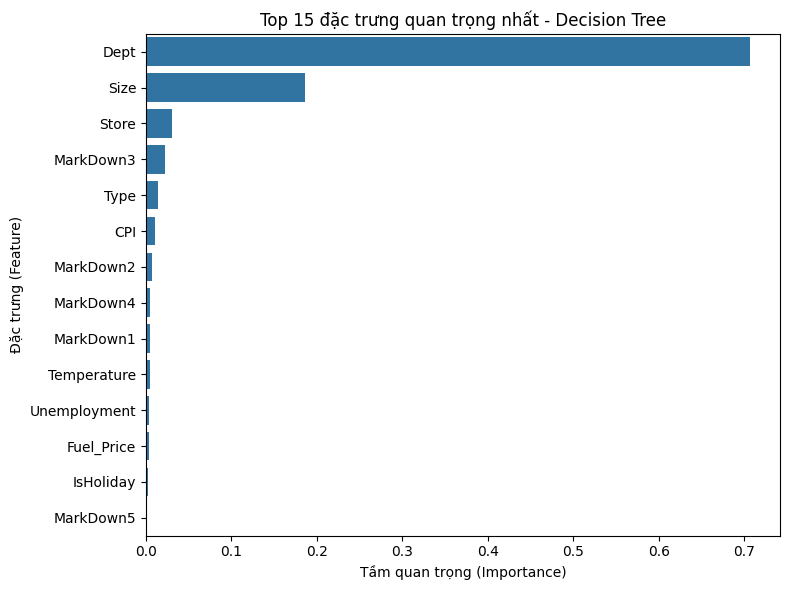

Top 15 đặc trưng quan trọng nhất:
         Feature  Importance
1           Dept    0.706271
13          Size    0.185639
0          Store    0.030943
7      MarkDown3    0.022319
12          Type    0.013900
10           CPI    0.010958
6      MarkDown2    0.007089
8      MarkDown4    0.004741
5      MarkDown1    0.004581
3    Temperature    0.004259
11  Unemployment    0.003261
4     Fuel_Price    0.003237
2      IsHoliday    0.002357
9      MarkDown5    0.000443


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Trích xuất feature importance từ mô hình đã huấn luyện
feature_importances = tree.feature_importances_

# 2. Tạo DataFrame cho việc trực quan hóa
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

# 3. Trực quan hóa Top 15 đặc trưng quan trọng
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title('Top 15 đặc trưng quan trọng nhất - Decision Tree')
plt.xlabel('Tầm quan trọng (Importance)')
plt.ylabel('Đặc trưng (Feature)')
plt.tight_layout()
plt.show()

# 4. In bảng giá trị cụ thể
print("Top 15 đặc trưng quan trọng nhất:")
print(importance_df.head(15))


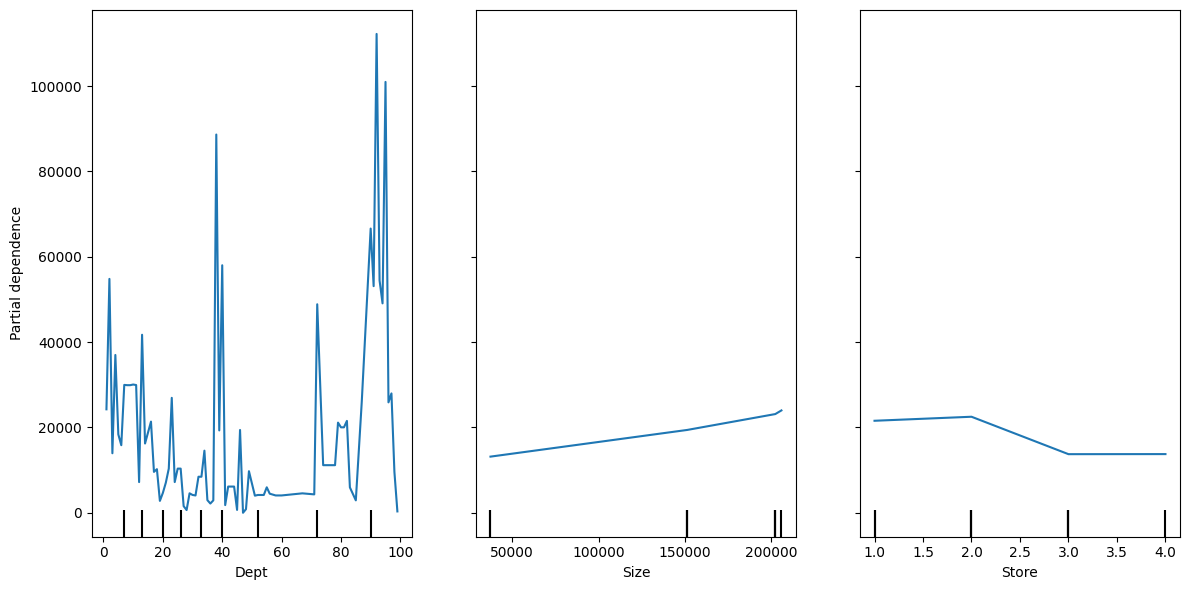

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

# Chọn đặc trưng để vẽ
selected_features = ['Dept', 'Size', 'Store']

# Vẽ Partial Dependence
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(tree, X_train, selected_features, ax=ax)
plt.tight_layout()
plt.show()



# 8. Triển khai mô hình và tạo dự báo

In [ ]:
from sklearn.tree import DecisionTreeRegressor

print("Đang huấn luyện mô hình Decision Tree Regressor...")
model = DecisionTreeRegressor(max_depth=10, random_state=42)
model.fit(X, y)


Đang huấn luyện mô hình Decision Tree Regressor...


DecisionTreeRegressor(max_depth=10, random_state=42)

In [ ]:
def preprocess_customer_data(customer_df):
    customer_df["Date"] = pd.to_datetime(customer_df["Date"])
    customer_df["Year"] = customer_df["Date"].dt.year
    customer_df["Month"] = customer_df["Date"].dt.month
    customer_df["Week"] = customer_df["Date"].dt.isocalendar().week

    # One-hot encoding
    customer_df = pd.get_dummies(customer_df, columns=["Type", "IsHoliday"], drop_first=True)

    # Bổ sung cột còn thiếu
    for col in X.columns:
        if col not in customer_df.columns:
            customer_df[col] = 0

    return customer_df[X.columns]

def predict_sales(customer_df):
    processed = preprocess_customer_data(customer_df)
    return model.predict(processed)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor

# ===== 1. Đọc và xử lý dữ liệu =====
train = pd.read_csv("/content/train.csv")
features_df = pd.read_csv("/content/features.csv")
stores = pd.read_csv("/content/stores.csv")
test = pd.read_csv("/content/test.csv")

# Gộp dữ liệu huấn luyện
train_full = train.merge(features_df, on=["Store", "Date", "IsHoliday"], how="left")
train_full = train_full.merge(stores, on="Store", how="left")

# Tiền xử lý
train_full["Date"] = pd.to_datetime(train_full["Date"])
train_full["Year"] = train_full["Date"].dt.year
train_full["Month"] = train_full["Date"].dt.month
train_full["Week"] = train_full["Date"].dt.isocalendar().week
train_full = pd.get_dummies(train_full, columns=["Type"], drop_first=True)

# Đặc trưng
features = ['Store', 'Dept', 'IsHoliday', 'Temperature', 'Fuel_Price',
            'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',
            'CPI', 'Unemployment', 'Size', 'Year', 'Month', 'Week',
            'Type_B', 'Type_C']
for col in features:
    if col not in train_full.columns:
        train_full[col] = 0

X = train_full[features]
y = train_full['Weekly_Sales']

# ===== 2. Huấn luyện mô hình =====
print("Đang huấn luyện mô hình Decision Tree Regressor...")
model = DecisionTreeRegressor(max_depth=10, random_state=42)
model.fit(X, y)

# ===== 3. Hàm tiền xử lý & dự báo =====
def preprocess_customer_data(customer_df):
    customer_df["Date"] = pd.to_datetime(customer_df["Date"])
    customer_df["Year"] = customer_df["Date"].dt.year
    customer_df["Month"] = customer_df["Date"].dt.month
    customer_df["Week"] = customer_df["Date"].dt.isocalendar().week
    customer_df = pd.get_dummies(customer_df, columns=["Type"], drop_first=True)
    for col in features:
        if col not in customer_df.columns:
            customer_df[col] = 0
    return customer_df[features]

def predict_sales(customer_df):
    processed = preprocess_customer_data(customer_df)
    predictions = model.predict(processed)
    return predictions

# ===== 4. DEMO DỰ BÁO =====
print("\n DEMO DỰ BÁO DOANH SỐ VÀ PHÂN LOẠI RỦI RO:")

# Gộp test set
sample_customers = test.merge(features_df, on=["Store", "Date", "IsHoliday"], how="left")
sample_customers = sample_customers.merge(stores, on="Store", how="left")
sample_customers = sample_customers.sample(5, random_state=42)

# Điền missing value bằng giá trị trung vị từ train_full
sample_customers.fillna(train_full.median(numeric_only=True), inplace=True)

# Dự báo doanh số
predicted_sales = predict_sales(sample_customers)

# Phân loại rủi ro
risk_levels = pd.cut(predicted_sales, bins=[-1, 10000, 30000, float("inf")],
                     labels=["Rủi ro cao", "Rủi ro trung bình", "Rủi ro thấp"])

# Kết quả
results = sample_customers[["Store", "Dept", "Date"]].copy()
results["PredictedSales"] = predicted_sales
results["RiskLevel"] = risk_levels

print(results)



Đang huấn luyện mô hình Decision Tree Regressor...

 DEMO DỰ BÁO DOANH SỐ VÀ PHÂN LOẠI RỦI RO:
       Store  Dept       Date  PredictedSales          RiskLevel
41889     16    46 2013-06-21    16751.195787  Rủi ro trung bình
94849     37    14 2013-06-14     1540.121713         Rủi ro cao
47097     18    42 2013-05-17     6732.413591         Rủi ro cao
76656     29    31 2013-07-05     2878.306613         Rủi ro cao
25182     10    35 2013-01-18     3238.126922         Rủi ro cao


In [ ]:
# ===== 2. HUẤN LUYỆN MÔ HÌNH =====
print("Đang huấn luyện mô hình Decision Tree Regressor...")
model = DecisionTreeRegressor(random_state=42)
model.fit(X, y)

# ===== 3. HÀM DỰ BÁO DOANH SỐ =====
def preprocess_customer_data(customer_df):
    customer_df["Date"] = pd.to_datetime(customer_df["Date"])
    customer_df["Year"] = customer_df["Date"].dt.year
    customer_df["Month"] = customer_df["Date"].dt.month
    customer_df["Week"] = customer_df["Date"].dt.isocalendar().week
    customer_df = pd.get_dummies(customer_df, columns=["Type", "IsHoliday"], drop_first=True)

    # Đảm bảo các cột khớp với X
    for col in X.columns:
        if col not in customer_df.columns:
            customer_df[col] = 0
    customer_df = customer_df[X.columns]  # Đảm bảo đúng thứ tự cột
    return customer_df

def predict_sales(customer_df):
    processed = preprocess_customer_data(customer_df)
    predictions = model.predict(processed)
    return predictions

# ===== 4. DEMO DỰ ĐOÁN & PHÂN LOẠI RỦI RO =====
print("\n===== DEMO DỰ BÁO GIỮ CHÂN KHÁCH HÀNG =====")

# Lấy ngẫu nhiên 5 khách hàng từ test set
sample_customers = test.merge(features_df, on=["Store", "Date", "IsHoliday"], how="left")
sample_customers = sample_customers.merge(stores, on="Store", how="left")
sample_customers = sample_customers.sample(5, random_state=42)
sample_customers.fillna(train_full.median(numeric_only=True), inplace=True)

# Dự báo doanh số
predicted_sales = predict_sales(sample_customers)

# Phân loại mức độ rủi ro theo doanh số
risk_levels = pd.cut(
    predicted_sales,
    bins=[-1, 10000, 30000, float("inf")],
    labels=["Rủi ro cao", "Rủi ro trung bình", "Rủi ro thấp"]
)

results = pd.DataFrame({
    "CustomerID": range(1, 6),
    "PredictedSales": predicted_sales,
    "RiskLevel": risk_levels
})

print(results)

# ===== 5. PHÂN TÍCH ROI =====
print("\n===== PHÂN TÍCH ROI CHƯƠNG TRÌNH GIỮ CHÂN =====")

# Giả định chi phí & doanh thu
acquisition_cost = 500_000     # Chi phí thu hút KH mới (VND)
retention_cost = 200_000       # Chi phí giữ chân 1 KH (VND)
monthly_revenue = 300_000      # Doanh thu mỗi tháng nếu giữ được KH (VND)
months = 12                    # Số tháng giữ chân trung bình
success_rate = 0.4             # Tỷ lệ giữ chân thành công

# Tính toán cho nhóm rủi ro cao
high_risk_count = (results["RiskLevel"] == "Rủi ro cao").sum()
retained_revenue = success_rate * high_risk_count * monthly_revenue * months
retention_expense = high_risk_count * retention_cost
avoided_acquisition_cost = success_rate * high_risk_count * acquisition_cost

roi = (retained_revenue + avoided_acquisition_cost - retention_expense) / retention_expense * 100

# Hiển thị kết quả
print(f"- Số khách hàng rủi ro cao: {high_risk_count}")
print(f"- Doanh thu giữ chân ước tính: {retained_revenue:,.0f} VND")
print(f"- Chi phí giữ chân: {retention_expense:,.0f} VND")
print(f"- Tránh được chi phí thu hút KH mới: {avoided_acquisition_cost:,.0f} VND")
print(f"==> ROI ƯỚC TÍNH: {roi:.2f}%")
# ===== 5. CHIẾN LƯỢC GIỮ CHÂN KHÁCH HÀNG =====
print("\n===== CHIẾN LƯỢC GIỮ CHÂN KHÁCH HÀNG THEO RỦI RO =====")
print("1. RỦI RO CAO (p > 0.7):")
print("   - Liên hệ trực tiếp qua điện thoại")
print("   - Ưu đãi giảm giá 20% trong 3 tháng")
print("   - Nâng cấp miễn phí các dịch vụ bổ sung")
print("2. RỦI RO TRUNG BÌNH (0.3 < p < 0.7):")
print("   - Gửi email cá nhân hóa")
print("   - Ưu đãi giảm giá 10% trong 3 tháng")
print("   - Khảo sát mức độ hài lòng")
print("3. RỦI RO THẤP (p < 0.3):")
print("   - Duy trì liên lạc thông thường")
print("   - Chương trình khách hàng thân thiết")

# ===== CHƯƠNG TRÌNH GIỮ CHÂN KHÁCH HÀNG =====
print("===== CHƯƠNG TRÌNH GIỮ CHÂN KHÁCH HÀNG =====")
print("Chiến lược tiếp cận theo mức độ rủi ro:")
# Kết quả phân loại
results = pd.DataFrame({
    'CustomerID': range(1, 6),
    'PredictedSales': predicted_sales,
    'RiskLevel': risk_levels
})
print("\nKết quả dự đoán:")
print(results)

# Chiến lược theo mức rủi ro
print("\n1. Rủi ro CAO (p > 0.7):")
print("   - Liên hệ trực tiếp qua điện thoại")
print("   - Ưu đãi giảm giá 20% trong 3 tháng")
print("   - Nâng cấp miễn phí các dịch vụ bổ sung")

print("\n2. Rủi ro TRUNG BÌNH (0.3 < p < 0.7):")
print("   - Gửi email cá nhân hóa")
print("   - Ưu đãi giảm giá 10% trong 3 tháng")
print("   - Khảo sát mức độ hài lòng")

print("\n3. Rủi ro THẤP (p < 0.3):")
print("   - Duy trì liên lạc thông thường")
print("   - Chương trình khách hàng thân thiết")

# ===== PHÂN TÍCH ROI =====
print("\n===== PHÂN TÍCH ROI =====")
print("Giả định:")
print("- Chi phí trung bình để thu hút khách hàng mới: 500,000 VND")
print("- Chi phí trung bình cho chương trình giữ chân: 200,000 VND/khách hàng")
print("- Tỷ lệ thành công của chương trình giữ chân: 30%")
print("- Doanh thu trung bình hàng tháng: 300,000 VND/khách hàng")
print("- Thời gian duy trì trung bình sau can thiệp: 12 tháng")

# Tính toán ROI cho nhóm rủi ro cao
num_high_risk = (results['RiskLevel'] == 'Cao').sum()

if num_high_risk > 0:
    retained_revenue = 0.3 * num_high_risk * 300_000 * 12
    retention_cost = num_high_risk * 200_000
    avoided_acquisition_cost = 0.3 * num_high_risk * 500_000

    roi = (retained_revenue + avoided_acquisition_cost - retention_cost) / retention_cost * 100

    print(f"\n- Số khách hàng rủi ro cao: {num_high_risk}")
    print(f"- Doanh thu giữ chân ước tính: {retained_revenue:,.0f} VND")
    print(f"- Chi phí giữ chân: {retention_cost:,.0f} VND")
    print(f"- Tránh được chi phí thu hút KH mới: {avoided_acquisition_cost:,.0f} VND")
    print(f"==> ROI ước tính: {roi:.2f}%")
else:
    print("\nKhông có khách hàng rủi ro cao trong mẫu để phân tích ROI.")


Đang huấn luyện mô hình Decision Tree Regressor...

===== DEMO DỰ BÁO GIỮ CHÂN KHÁCH HÀNG =====
   CustomerID  PredictedSales          RiskLevel
0           1        22243.48  Rủi ro trung bình
1           2         2154.76         Rủi ro cao
2           3         7031.20         Rủi ro cao
3           4         1672.60         Rủi ro cao
4           5         3465.99         Rủi ro cao

===== PHÂN TÍCH ROI CHƯƠNG TRÌNH GIỮ CHÂN =====
- Số khách hàng rủi ro cao: 4
- Doanh thu giữ chân ước tính: 5,760,000 VND
- Chi phí giữ chân: 800,000 VND
- Tránh được chi phí thu hút KH mới: 800,000 VND
==> ROI ƯỚC TÍNH: 720.00%

===== CHIẾN LƯỢC GIỮ CHÂN KHÁCH HÀNG THEO RỦI RO =====
1. RỦI RO CAO (p > 0.7):
   - Liên hệ trực tiếp qua điện thoại
   - Ưu đãi giảm giá 20% trong 3 tháng
   - Nâng cấp miễn phí các dịch vụ bổ sung
2. RỦI RO TRUNG BÌNH (0.3 < p < 0.7):
   - Gửi email cá nhân hóa
   - Ưu đãi giảm giá 10% trong 3 tháng
   - Khảo sát mức độ hài lòng
3. RỦI RO THẤP (p < 0.3):
   - Duy trì liên 

In [ ]:
import pandas as pd

# Giả sử chúng ta có dữ liệu về khách hàng, doanh thu và chiến lược giữ chân
data = {
    'CustomerID': [1, 2, 3, 4, 5],
    'ChurnProbability': [0.3, 0.8, 0.6, 0.9, 0.4],
    'PredictedSales': [22243.48, 2154.76, 7031.20, 1672.60, 3465.99],
    'RiskLevel': ['Trung bình', 'Cao', 'Cao', 'Cao', 'Cao'],
    'LoyaltyProgram': ['Chương trình thân thiết', 'Giảm giá 20%', 'Giảm giá 20%', 'Giảm giá 10%', 'Giảm giá 10%'],
    'ContactMethod': ['Email', 'Điện thoại', 'Điện thoại', 'Email', 'Điện thoại'],
    'RetentionDurationMonths': [12, 6, 9, 3, 8]  # Thời gian duy trì sau can thiệp (tháng)
}

# Chuyển dữ liệu vào DataFrame
df = pd.DataFrame(data)

# Thêm giả định về chi phí và doanh thu
customer_acquisition_cost = 500000  # Chi phí thu hút khách hàng mới (VND)
retention_program_cost = 200000  # Chi phí giữ chân khách hàng (VND/khách hàng)
average_monthly_revenue_per_customer = 300000  # Doanh thu hàng tháng từ mỗi khách hàng (VND)

# Tính toán tổng doanh thu giữ chân sau can thiệp
df['TotalRevenueAfterRetention'] = df['RetentionDurationMonths'] * average_monthly_revenue_per_customer

# Tính toán ROI cho mỗi khách hàng
df['RetentionCost'] = df['RetentionDurationMonths'] * retention_program_cost  # Chi phí giữ chân
df['ROI'] = (df['TotalRevenueAfterRetention'] - df['RetentionCost']) / df['RetentionCost'] * 100  # ROI (đơn vị: %)

# Phân tích chiến lược theo các yếu tố
high_risk_customers = df[df['RiskLevel'] == 'Cao']
medium_risk_customers = df[df['RiskLevel'] == 'Trung bình']

# Tính toán ROI tổng cho nhóm khách hàng
total_roi_high_risk = high_risk_customers['ROI'].mean()
total_roi_medium_risk = medium_risk_customers['ROI'].mean()

# Hiệu quả của các kênh liên lạc
contact_method_effectiveness = df.groupby('ContactMethod')['ROI'].mean()

# In kết quả phân tích
print("===== PHÂN TÍCH ROI CHI TIẾT =====")
print("\nROI trung bình cho khách hàng rủi ro cao:", total_roi_high_risk, "%")
print("ROI trung bình cho khách hàng rủi ro trung bình:", total_roi_medium_risk, "%")

print("\nHiệu quả ROI của các kênh liên lạc:")
print(contact_method_effectiveness)

# Tóm tắt kết quả
print("\nKết quả phân tích chiến lược giữ chân khách hàng:")
for index, row in df.iterrows():
    print(f"\nKhách hàng {row['CustomerID']} - Chương trình: {row['LoyaltyProgram']}")
    print(f"Doanh thu sau khi giữ chân: {row['TotalRevenueAfterRetention']} VND")
    print(f"Chi phí giữ chân: {row['RetentionCost']} VND")
    print(f"ROI: {row['ROI']}%")


===== PHÂN TÍCH ROI CHI TIẾT =====

ROI trung bình cho khách hàng rủi ro cao: 50.0 %
ROI trung bình cho khách hàng rủi ro trung bình: 50.0 %

Hiệu quả ROI của các kênh liên lạc:
ContactMethod
Email         50.0
Điện thoại    50.0
Name: ROI, dtype: float64

Kết quả phân tích chiến lược giữ chân khách hàng:

Khách hàng 1 - Chương trình: Chương trình thân thiết
Doanh thu sau khi giữ chân: 3600000 VND
Chi phí giữ chân: 2400000 VND
ROI: 50.0%

Khách hàng 2 - Chương trình: Giảm giá 20%
Doanh thu sau khi giữ chân: 1800000 VND
Chi phí giữ chân: 1200000 VND
ROI: 50.0%

Khách hàng 3 - Chương trình: Giảm giá 20%
Doanh thu sau khi giữ chân: 2700000 VND
Chi phí giữ chân: 1800000 VND
ROI: 50.0%

Khách hàng 4 - Chương trình: Giảm giá 10%
Doanh thu sau khi giữ chân: 900000 VND
Chi phí giữ chân: 600000 VND
ROI: 50.0%

Khách hàng 5 - Chương trình: Giảm giá 10%
Doanh thu sau khi giữ chân: 2400000 VND
Chi phí giữ chân: 1600000 VND
ROI: 50.0%
